DEEP LEARNING PROJECT 3 - team Deepest Learners

Submission by : Divij Kapur(dk4999), Amey Mittal (am15239) , Amratanshu Shrivastava (as19451)

In [ ]:
import os
import json
import shutil
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from zipfile import ZipFile
from torchvision.datasets import ImageFolder
import os
import json
import re

# Magic command for matplotlib in notebooks
%matplotlib inline

In [ ]:
zip_path = '/content/TestDataSet.zip'
out_dir  = '/content'

os.makedirs(out_dir, exist_ok=True)
with ZipFile(zip_path, 'r') as z:
    z.extractall(out_dir)

print(os.listdir(out_dir))

['.config', 'TestDataSet', 'TestDataSet.zip', '__MACOSX', 'sample_data']


In [ ]:
labels_json_path = "/content/TestDataSet/labels_list.json"
with open(labels_json_path, "r") as f:
    label_entries = json.load(f)

class_names = []
for entry in label_entries:
    match = re.match(r"\d+: (.+)", entry)
    if match:
        class_names.append(match.group(1).strip())

print(class_names[:10])

['accordion', 'acoustic guitar', 'aircraft carrier', 'airliner', 'airship', 'altar', 'ambulance', 'amphibian', 'analog clock', 'apiary']


In [ ]:
# Define the preprocessing transforms (as in your previous code)
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load the dataset
dataset_path = "/content/TestDataSet"
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)

In [ ]:
# dataset.classes gives you the WNIDs in the same order as your dataset
wnids = dataset.classes  # e.g., ['n02672831', 'n02676566', ...]

# Now, build a mapping from WNID to class name
wnid_to_class = {wnid: class_name for wnid, class_name in zip(wnids, class_names)}
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

print(list(wnid_to_class.items())[:5])

[('n02672831', 'accordion'), ('n02676566', 'acoustic guitar'), ('n02687172', 'aircraft carrier'), ('n02690373', 'airliner'), ('n02692877', 'airship')]


In [ ]:
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

<font size="45">Task 1</font>

### Model Evaluation on Clean Test Set

This cell evaluates a pre-trained ResNet-34 model on the clean (unperturbed) test dataset:

- Applies standard ImageNet normalization to all test images.
- Loads the dataset using `torchvision.datasets.ImageFolder`.
- Parses `labels_list.json` to build mappings between WordNet IDs and class labels.
- Loads the ImageNet-1K pretrained ResNet-34 model in evaluation mode.
- Computes **Top-1** and **Top-5** accuracy by comparing predicted class indices with ground-truth labels.
- Prints accuracy scores for further comparison with adversarial results.


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
mean_norms = np.array([0.485, 0.456, 0.406]) # Define the preprocessing transforms.
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
dataset_path = "/content/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False) # Create a DataLoader for the dataset with a batch size of 32, keeping the data order unchanged for evaluation

# Load label mapping from labels_list.json
labels_json_path = "/content/TestDataSet/labels_list.json"
with open(labels_json_path, "r") as f: # Open and read the JSON file containing label information
    label_entries = json.load(f)


# Extract class names from the label entries
class_names = []
for entry in label_entries:
    match = re.match(r"\d+: (.+)", entry) # Use regex to extract the class name from each entry (formatted as "id: class_name")
    if match:
        class_names.append(match.group(1).strip())

wnids = dataset.classes
wnid_to_label = {wnid: class_name for wnid, class_name in zip(wnids, class_names)}
label_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# 4. Load pretrained ResNet-34
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# 5. Evaluation code (use this for both clean and adversarial images)
def evaluate_model(data_loader, dataset, wnid_to_label, label_to_idx):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)
        for i in range(images.size(0)):
            # Map true label to the corresponding WordNet ID and class name
            true_wnid = dataset.classes[labels[i].item()]
            true_class_name = wnid_to_label[true_wnid]
            true_imagenet_idx = label_to_idx[true_class_name] + 401  # adjust offset if needed

            # Check Top-1 accuracy
            if predicted[i].item() == true_imagenet_idx:
                correct_top1 += 1

            # Check Top-5 accuracy
            if true_imagenet_idx in top5_preds[i].tolist():
                correct_top5 += 1

            total += 1
    top1_accuracy = 100. * correct_top1 / total
    top5_accuracy = 100. * correct_top5 / total
    print(f'Top-1 Accuracy: {top1_accuracy:.2f}%')
    print(f'Top-5 Accuracy: {top5_accuracy:.2f}%')
    return top1_accuracy, top5_accuracy

# 6. Run evaluation on the clean test set
top1_accuracy, top5_accuracy  = evaluate_model(test_loader, dataset, wnid_to_label, label_to_idx)

Using device: cuda
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


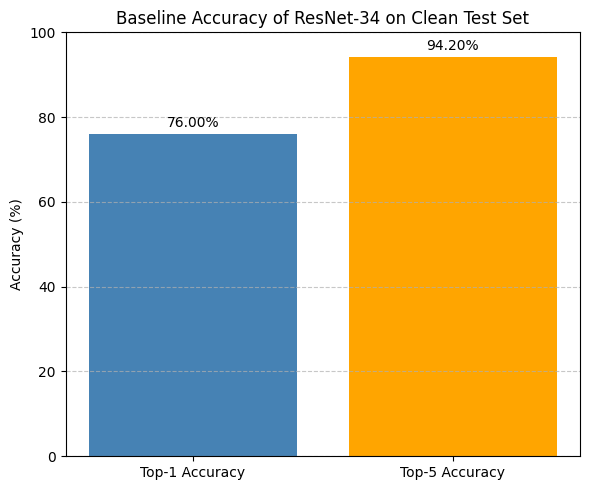

In [ ]:
import matplotlib.pyplot as plt

# Labels and values
metrics = ['Top-1 Accuracy', 'Top-5 Accuracy']
values = [top1_accuracy, top5_accuracy]

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, color=['steelblue', 'orange'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Baseline Accuracy of ResNet-34 on Clean Test Set')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<h1>How is Top-k Accuracy Calculated?</h1>
Top-k accuracy is determined through the following steps:

1. For each input image, the model generates a list of class probabilities.
2. The k class labels with the highest probabilities are identified.
3. If the actual (ground truth) label is among these k predictions, it is considered correct for top-k accuracy.

* *Top-1 accuracy* measures the percentage of cases where the top predicted label matches the ground truth.
* *Top-5 accuracy* measures the percentage of cases where the ground truth is among the top five predicted labels.

If asked, "What are your results?" respond as follows:

* *Top-1 Accuracy*: 76.00%
* *Top-5 Accuracy*: 94.20%

<font size="45">Task 2</font>

### FGSM Adversarial Attack: Generation and Evaluation

The below cells define and run the complete FGSM-based adversarial attack pipeline:

- **Model & Label Loading**: Loads a pretrained ResNet-34 model and parses the `labels_list.json` to map class names to indices.
- **FGSM Attack Function**: Implements the Fast Gradient Sign Method (FGSM) to craft adversarial images by perturbing the input in the direction of the gradient sign, constrained under the $L_{\infty}$ norm with $\epsilon = 0.02$.
- **Model Evaluation**: Evaluates the model on clean and adversarial images, computing Top-1 and Top-5 accuracy.
- **Verification Step**:
  - Ensures all perturbations are within the specified $\epsilon$-bound.
  - Calculates $L_{\infty}$ distances between original and perturbed images.
  - Logs original and adversarial performance along with accuracy drops to a results file.

This task demonstrates how even single-step adversarial perturbations can cause severe accuracy degradation in deep models.


In [ ]:
def load_model():
    # Load pretrained ResNet-34 with updated weights parameter
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.eval()
    return model

def load_labels(labels_json_path):
    with open(labels_json_path, "r") as f:
        label_entries = json.load(f)

    # Build a list of class names and their corresponding ImageNet IDs
    class_names = []
    class_ids = []
    for entry in label_entries:
        match = re.match(r"(\d+): (.+)", entry)
        if match:
            class_id = int(match.group(1))
            class_name = match.group(2).strip()
            class_names.append(class_name)
            class_ids.append(class_id)

    return class_names, class_ids

In [ ]:
def fgsm_attack(image, epsilon, data_grad, mean_norms, std_norms):
    # Convert mean and std to tensors with proper shape and type
    mean_tensor = torch.tensor(mean_norms, device=image.device, dtype=torch.float32).view(3, 1, 1)
    std_tensor = torch.tensor(std_norms, device=image.device, dtype=torch.float32).view(3, 1, 1)
    image = image.float()
    # Denormalize image
    image_denorm = image * std_tensor + mean_tensor
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Scale epsilon by std for proper perturbation size
    epsilon_scaled = epsilon * std_tensor
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image_denorm + epsilon_scaled * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Normalize back
    perturbed_image = (perturbed_image - mean_tensor) / std_tensor

    return perturbed_image

In [ ]:
def evaluate_model(model, dataloader, device, dataset, wnid_to_class, class_to_idx):
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

            for i in range(images.size(0)):
                true_wnid = dataset.classes[labels[i].item()]
                true_class_name = wnid_to_class[true_wnid]
                true_imagenet_idx = class_to_idx[true_class_name] + 401  # adjust offset if needed

                if predicted[i].item() == true_imagenet_idx:
                    correct_top1 += 1
                if true_imagenet_idx in top5_preds[i].tolist():
                    correct_top5 += 1
                total += 1

    top1_accuracy = 100. * correct_top1 / total
    top5_accuracy = 100. * correct_top5 / total
    return top1_accuracy, top5_accuracy

In [ ]:
def verify_adversarial_examples(original_images, perturbed_images, epsilon, original_top1, original_top5, adversarial_top1, adversarial_top5):
    # Calculate L∞ distance for each image pair
    distances = []
    for orig, pert in zip(original_images, perturbed_images):
        # Calculate absolute difference
        diff = torch.abs(pert - orig)
        # Get maximum difference (L∞ norm)
        max_diff = torch.max(diff).item()
        distances.append(max_diff)

    # Convert to numpy for easier analysis
    distances = np.array(distances)

    # Use a small tolerance for floating-point comparisons
    tolerance = 1e-6
    within_limit = np.sum(distances <= epsilon + tolerance)

    # Calculate accuracy drops
    top1_drop = original_top1 - adversarial_top1
    top5_drop = original_top5 - adversarial_top5

    # Print statistics
    print("\nVerification Results:")
    print(f"Number of images: {len(distances)}")
    print(f"Maximum L∞ distance: {np.max(distances):.6f}")
    print(f"Minimum L∞ distance: {np.min(distances):.6f}")
    print(f"Mean L∞ distance: {np.mean(distances):.6f}")
    print(f"Images within ε={epsilon} limit: {within_limit}/{len(distances)}")

    # Save verification results
    with open('adversarial_test_set_1/verification_results.txt', 'w') as f:
        f.write(f"Verification Results for Adversarial Test Set 1\n")
        f.write(f"=============================================\n")
        f.write(f"Number of images: {len(distances)}\n")
        f.write(f"Maximum L∞ distance: {np.max(distances):.6f}\n")
        f.write(f"Minimum L∞ distance: {np.min(distances):.6f}\n")
        f.write(f"Mean L∞ distance: {np.mean(distances):.6f}\n")
        f.write(f"Images within ε={epsilon} limit: {within_limit}/{len(distances)}\n")
        f.write(f"\nOriginal Model Accuracy:\n")
        f.write(f"Top-1: {original_top1:.2f}%\n")
        f.write(f"Top-5: {original_top5:.2f}%\n")
        f.write(f"\nAdversarial Model Accuracy:\n")
        f.write(f"Top-1: {adversarial_top1:.2f}%\n")
        f.write(f"Top-5: {adversarial_top5:.2f}%\n")
        f.write(f"\nAccuracy Drop:\n")
        f.write(f"Top-1: {top1_drop:.2f}%\n")
        f.write(f"Top-5: {top5_drop:.2f}%\n")


This task implements and visualizes the Fast Gradient Sign Method (FGSM) for generating adversarial examples under an $L_{\infty}$ constraint with $\epsilon = 0.02$.

**Key steps:**
- Loads a pretrained ResNet-34 model and label mappings.
- Applies standard ImageNet normalization and evaluates model accuracy on the clean test set.
- Generates adversarial examples by computing the gradient of the loss with respect to the input and applying a one-step perturbation in the direction of the sign of the gradient.
- Visualizes the effect of the attack by comparing original and perturbed images, showing predicted class labels.
- Saves both original and adversarial images to disk.
- Evaluates model performance on adversarial inputs and compares **Top-1** and **Top-5** accuracy to clean inputs using a bar chart.

This pipeline highlights how even a small perturbation can cause the model to fail, revealing its sensitivity to adversarial noise.


In [ ]:
def visualize_attacks(original_images, perturbed_images, labels, predictions, class_names, epsilon, num_samples=5):
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2*i + 1)
        # Denormalize and convert to numpy for visualization
        orig_img = original_images[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(orig_img)

        # Get true class name
        true_class_idx = labels[i].item()
        true_class_name = class_names[true_class_idx]

        # Get predicted class name (adjust for ImageNet offset)
        pred_idx = predictions[i].item()
        pred_class_name = class_names[pred_idx - 401] if 401 <= pred_idx <= 500 else "Unknown"

        plt.title(f'Original\nTrue: {true_class_name}\nPred: {pred_class_name}')
        plt.axis('off')

        # Perturbed image
        plt.subplot(num_samples, 2, 2*i + 2)
        # Denormalize and convert to numpy for visualization
        pert_img = perturbed_images[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
        pert_img = np.clip(pert_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(pert_img)
        plt.title(f'Perturbed (ε={epsilon})\nTrue: {true_class_name}\nPred: {pred_class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('task2_fgsm_attack_visualization.png')
    #plt.show()
    plt.close()

Using device: cuda
Evaluating original model...


100%|██████████| 16/16 [00:01<00:00, 12.15it/s]


Original Model - Top-1 Accuracy: 70.60%, Top-5 Accuracy: 93.20%


100%|██████████| 16/16 [00:01<00:00,  8.53it/s]



Evaluating model on adversarial examples...


100%|██████████| 16/16 [00:00<00:00, 67.54it/s]


Adversarial Model - Top-1 Accuracy: 5.00%, Top-5 Accuracy: 30.40%

Accuracy Drop - Top-1: 65.60%, Top-5: 62.80%


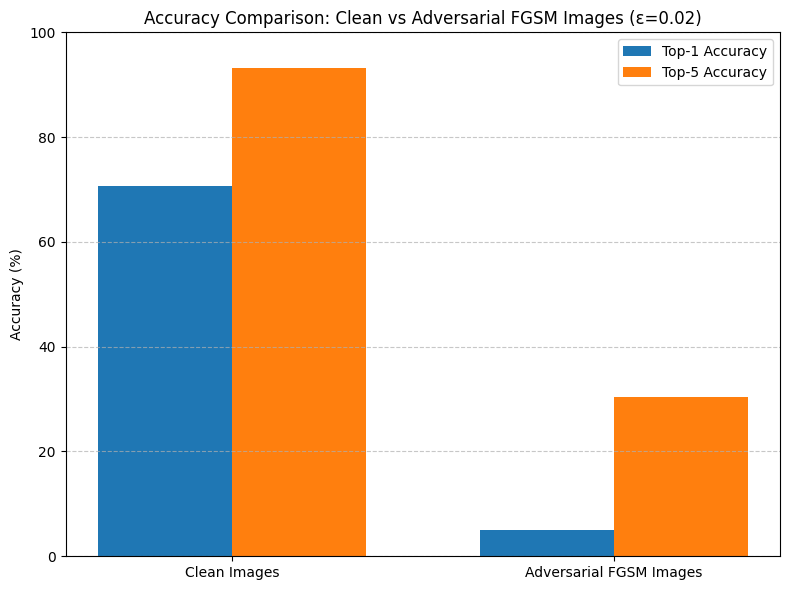

In [ ]:
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load model
    model = load_model().to(device)

    # Load class names and IDs
    labels_json_path = "/content/TestDataSet/labels_list.json"
    class_names, class_ids = load_labels(labels_json_path)

    # Define transformations
    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    # Load dataset
    dataset_path = "/content/TestDataSet"
    dataset = ImageFolder(root=dataset_path, transform=transform)
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Create mappings
    wnids = dataset.classes
    wnid_to_class = {wnid: class_name for wnid, class_name in zip(wnids, class_names)}
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    epsilon = 0.02
    perturbed_images = []
    original_images = []
    true_labels = []
    predictions = []

    # Evaluate original model
    print("Evaluating original model...")
    original_top1, original_top5 = evaluate_model(model, test_loader, device, dataset, wnid_to_class, class_to_idx)
    print(f"Original Model - Top-1 Accuracy: {original_top1:.2f}%, Top-5 Accuracy: {original_top5:.2f}%")

    # Generate adversarial examples
    model.eval()
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        # Forward pass
        outputs = model(images)

        # Get the true class indices (401-500)
        true_indices = torch.tensor([class_to_idx[wnid_to_class[dataset.classes[label.item()]]] + 401 for label in labels], device=device)

        # Calculate loss with respect to true indices
        loss = nn.CrossEntropyLoss()(outputs, true_indices)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Generate perturbed images using FGSM
        perturbed = fgsm_attack(images, epsilon, images.grad.data, mean_norms, std_norms)

        # Store results
        perturbed_images.extend(perturbed.detach().cpu())
        original_images.extend(images.detach().cpu())
        true_labels.extend(labels.cpu())

        # Get predictions on perturbed images
        with torch.no_grad():
            outputs = model(perturbed)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu())

    # Visualize some examples
    visualize_attacks(
        torch.stack(original_images[:5]),
        torch.stack(perturbed_images[:5]),
        true_labels[:5],
        predictions[:5],
        class_names,
        epsilon
    )

    # Save adversarial dataset
    os.makedirs('adversarial_test_set_1', exist_ok=True)
    for i, (orig, pert) in enumerate(zip(original_images, perturbed_images)):
        # Denormalize images before saving
        orig_img = transforms.ToPILImage()(orig * torch.tensor(std_norms).view(3, 1, 1) + torch.tensor(mean_norms).view(3, 1, 1))
        pert_img = transforms.ToPILImage()(pert * torch.tensor(std_norms).view(3, 1, 1) + torch.tensor(mean_norms).view(3, 1, 1))

        # Save images
        orig_img.save(f'adversarial_test_set_1/original_{i}.png')
        pert_img.save(f'adversarial_test_set_1/perturbed_{i}.png')

    # Create a new dataloader for adversarial examples
    adversarial_dataset = torch.utils.data.TensorDataset(
        torch.stack(perturbed_images),
        torch.tensor(true_labels)
    )
    adversarial_loader = DataLoader(adversarial_dataset, batch_size=32, shuffle=False)

    # Evaluate model on adversarial examples
    print("\nEvaluating model on adversarial examples...")
    adversarial_top1, adversarial_top5 = evaluate_model(model, adversarial_loader, device, dataset, wnid_to_class, class_to_idx)
    print(f"Adversarial Model - Top-1 Accuracy: {adversarial_top1:.2f}%, Top-5 Accuracy: {adversarial_top5:.2f}%")

    # Calculate accuracy drop
    top1_drop = original_top1 - adversarial_top1
    top5_drop = original_top5 - adversarial_top5
    print(f"\nAccuracy Drop - Top-1: {top1_drop:.2f}%, Top-5: {top5_drop:.2f}%")

    labels = ['Clean Images', 'Adversarial FGSM Images']  # Changed from 'Patch' to 'FGSM' to match this version
    top1_scores = [original_top1, adversarial_top1]
    top5_scores = [original_top5, adversarial_top5]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 6))
    plt.bar([i - width/2 for i in x], top1_scores, width=width, label='Top-1 Accuracy')
    plt.bar([i + width/2 for i in x], top5_scores, width=width, label='Top-5 Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Accuracy Comparison: Clean vs Adversarial FGSM Images (ε={epsilon})')
    plt.xticks(x, labels)
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()





### Results

We implemented the Fast Gradient Sign Method (FGSM) with $\epsilon = 0.02$ to generate adversarial examples from clean images by adding small perturbations in the gradient direction.

**Performance:**
- **Clean Images:** Top-1 Accuracy = 70.60%, Top-5 Accuracy = 93.20%
- **Adversarial Images:** Top-1 Accuracy = 5.00%, Top-5 Accuracy = 30.40%
- **Accuracy Drop:** Top-1 ↓ 65.60%, Top-5 ↓ 62.80%

These results confirm the model's vulnerability to even minor perturbations. The bar plot below visualizes this sharp performance drop, highlighting the effectiveness of FGSM in misleading the classifier.


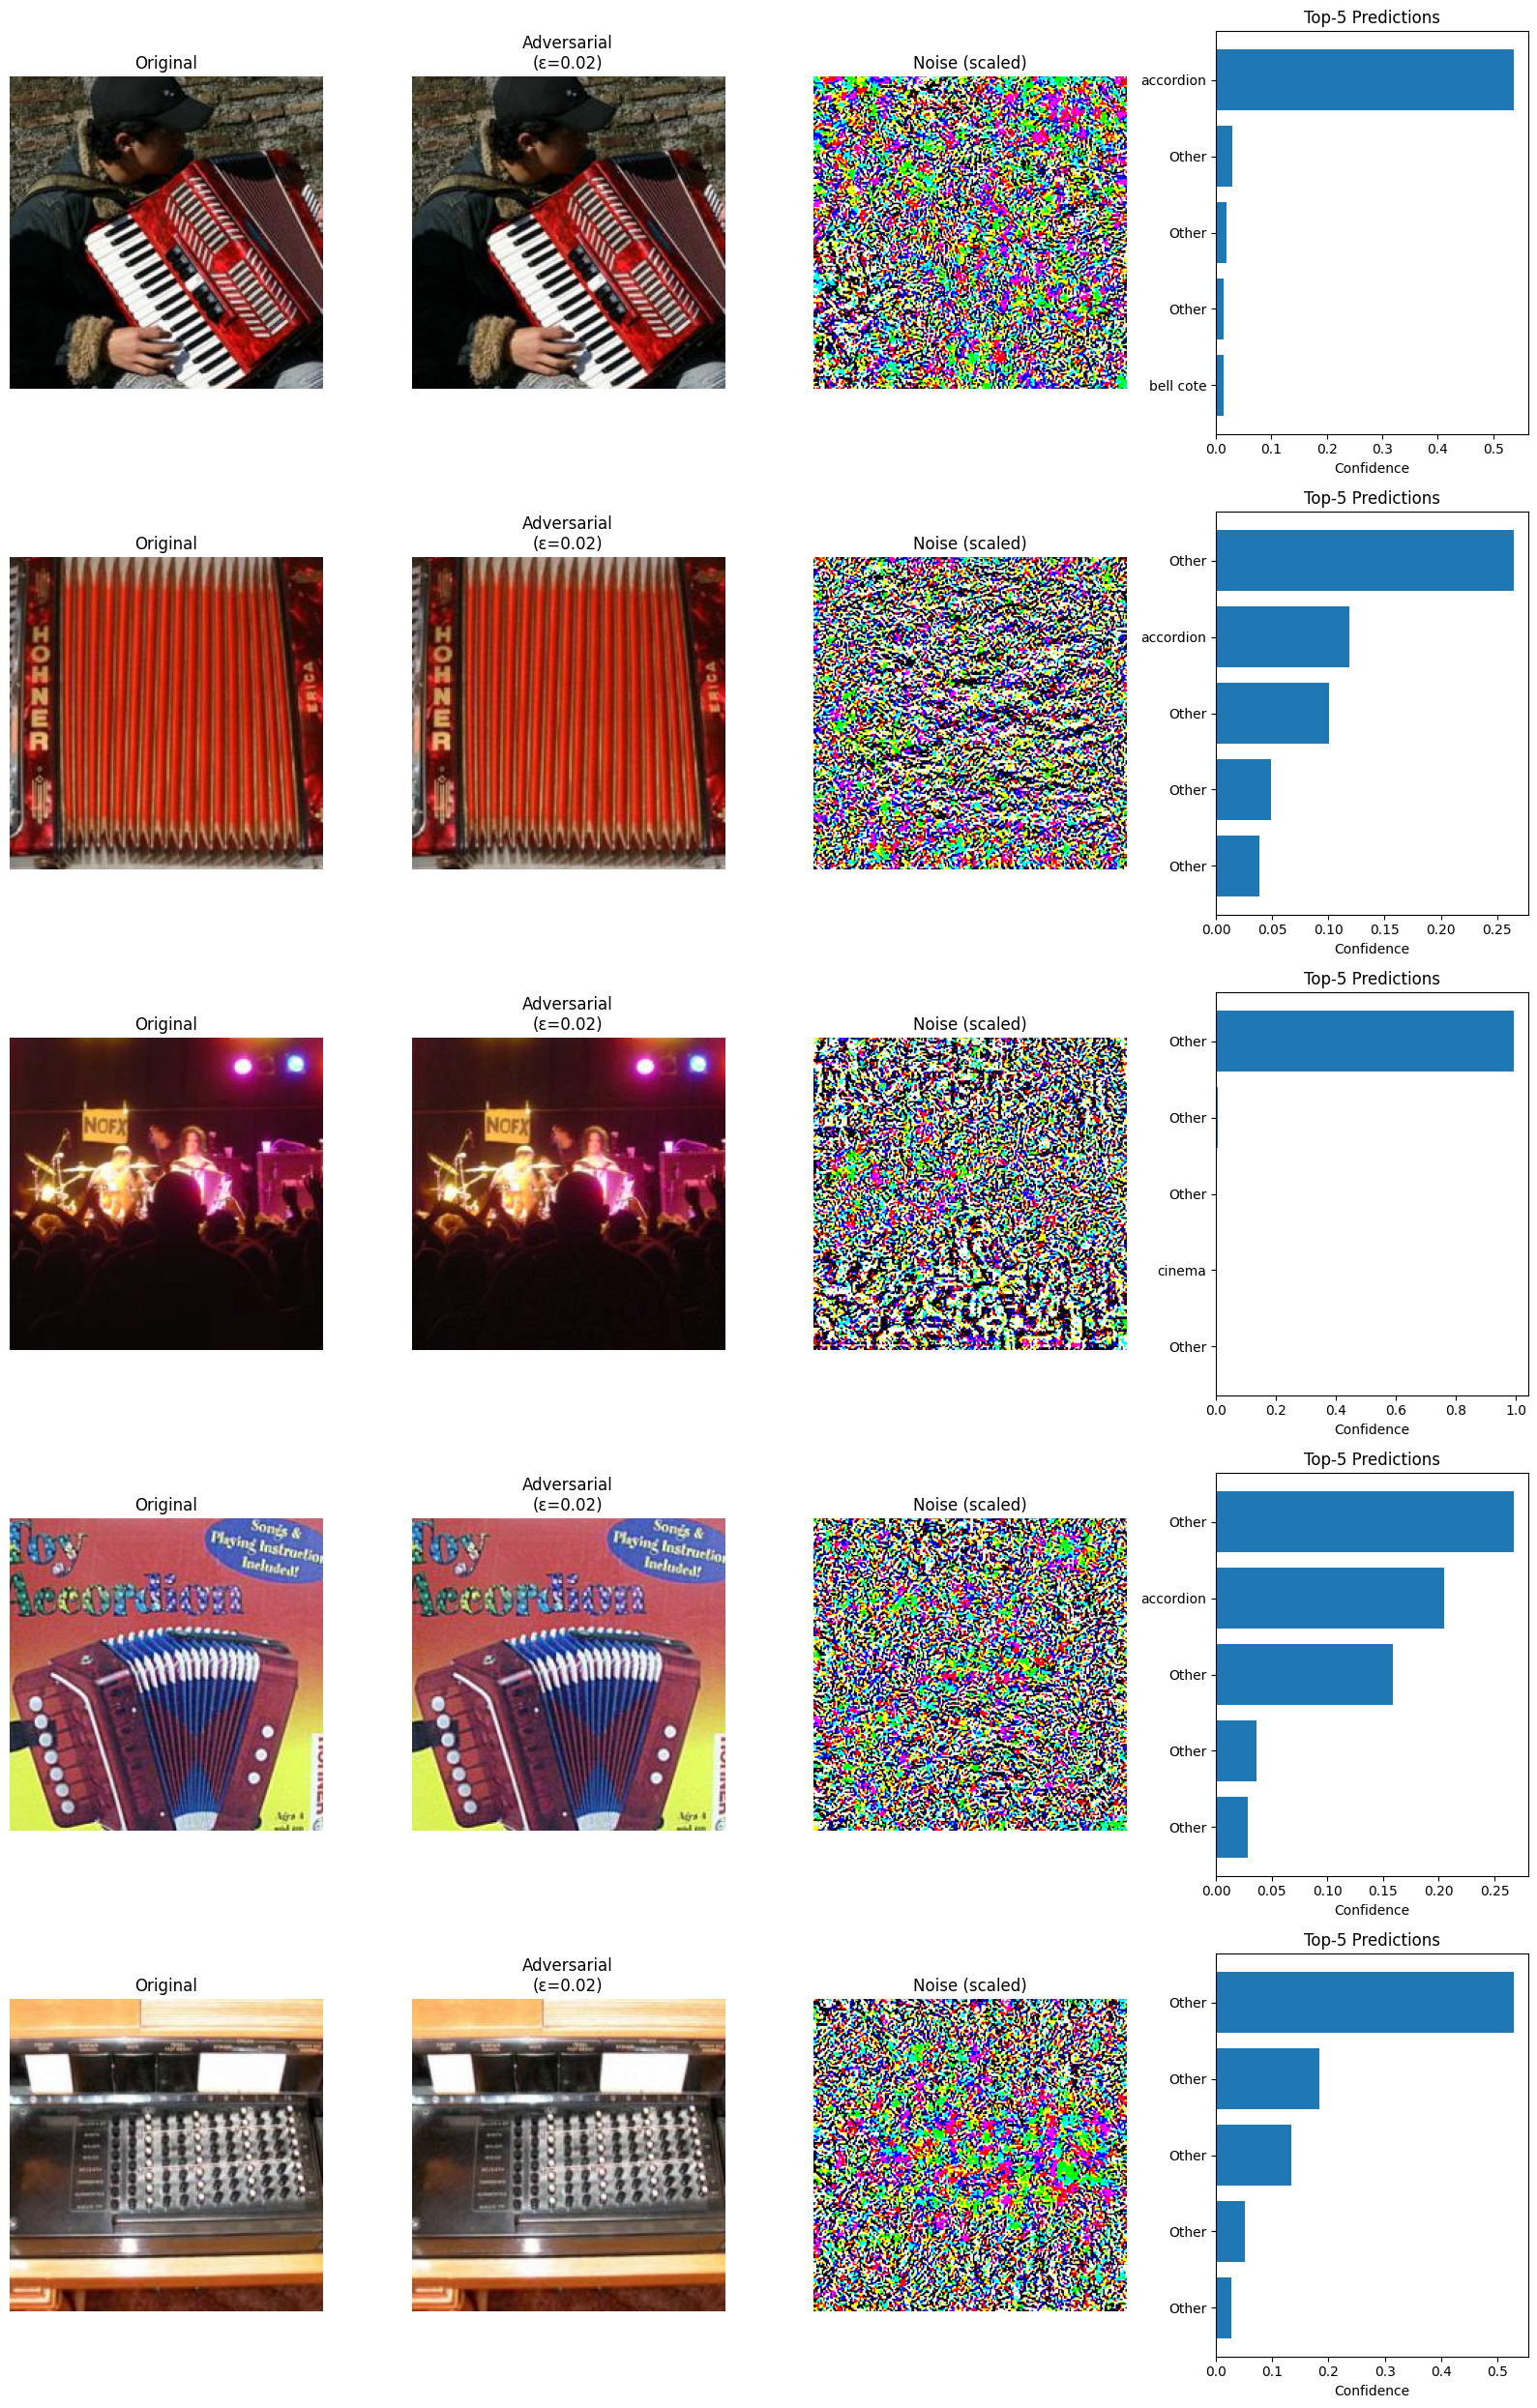

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- FGSM attack (your existing implementation) ---
def fgsm_attack(image, epsilon, data_grad, mean_norms, std_norms):
    mean_tensor = torch.tensor(mean_norms, device=image.device, dtype=torch.float32).view(3,1,1)
    std_tensor  = torch.tensor(std_norms, device=image.device, dtype=torch.float32).view(3,1,1)
    image_denorm = image * std_tensor + mean_tensor

    sign_data_grad = data_grad.sign()
    epsilon_scaled = epsilon * std_tensor

    perturbed = image_denorm + epsilon_scaled * sign_data_grad
    perturbed = torch.clamp(perturbed, 0, 1)
    perturbed = (perturbed - mean_tensor) / std_tensor
    return perturbed

# --- Visualization (with proper .detach() calls) ---
def visualize_with_noise_and_top5(orig_imgs, adv_imgs, data_grads,
                                  model, class_to_idx, idx_to_wnid,
                                  wnid_to_class, epsilon, num_samples=3):
    offset = 401
    num_json = len(idx_to_wnid)
    plt.figure(figsize=(16, 5 * num_samples))

    for i in range(num_samples):
        # detach before any numpy() call
        orig = orig_imgs[i].detach()
        adv  = adv_imgs[i].detach()
        grad = data_grads[i].detach()

        # 1) Original
        plt.subplot(num_samples, 4, 4*i + 1)
        img = orig.permute(1,2,0).numpy()
        img = np.clip(img * std_norms + mean_norms, 0, 1)
        plt.imshow(img); plt.title("Original"); plt.axis('off')

        # 2) Adversarial
        plt.subplot(num_samples, 4, 4*i + 2)
        img_adv = adv.permute(1,2,0).numpy()
        img_adv = np.clip(img_adv * std_norms + mean_norms, 0, 1)
        plt.imshow(img_adv); plt.title(f"Adversarial\n(ε={epsilon})"); plt.axis('off')

        # 3) Noise (scaled)
        plt.subplot(num_samples, 4, 4*i + 3)
        noise_img = (epsilon * grad.sign()).permute(1,2,0).numpy()
        # shift from [-ε,+ε] to [0,1]
        noise_disp = (noise_img + epsilon) / (2 * epsilon)
        plt.imshow(noise_disp); plt.title("Noise (scaled)"); plt.axis('off')

        # 4) Top‑5 Predictions
        plt.subplot(num_samples, 4, 4*i + 4)
        with torch.no_grad():
            out = model(adv.unsqueeze(0).to(device))
            probs = torch.softmax(out, dim=1).cpu().squeeze()
        top5 = torch.topk(probs, 5)
        confs = top5.values.numpy()
        inds  = top5.indices.numpy()

        labels = []
        for idx in inds:
            if offset <= idx < offset + num_json:
                json_idx = idx - offset
                wnid     = idx_to_wnid[json_idx]
                labels.append(wnid_to_class.get(wnid, "Unknown"))
            else:
                labels.append("Other")

        plt.barh(range(5), confs[::-1])
        plt.yticks(range(5), labels[::-1])
        plt.xlabel("Confidence")
        plt.title("Top‑5 Predictions")
        plt.tight_layout()

    plt.show()

# --- MAIN: grab a batch, compute grads, perturb, and visualize ---
# (assumes these are already in your notebook’s global scope:
#   test_loader, model, mean_norms, std_norms,
#   class_to_idx, dataset.classes, wnid_to_class
# )

epsilon = 0.02

# 1) Grab one batch
orig_batch, labels_batch = next(iter(test_loader))
orig_batch = orig_batch.to(device)
labels_batch = labels_batch.to(device)

# 2) Compute gradients w.r.t. inputs
orig_batch.requires_grad_(True)
outputs = model(orig_batch)
true_indices = torch.tensor(
    [ class_to_idx[ wnid_to_class[ dataset.classes[l.item()] ] ] + 401
      for l in labels_batch ],
    device=device
)
loss = torch.nn.CrossEntropyLoss()(outputs, true_indices)
model.zero_grad()
loss.backward()

# 3) Generate adversarial images & grab the gradient
grads     = orig_batch.grad.detach().cpu()
adv_batch = fgsm_attack(orig_batch, epsilon, orig_batch.grad, mean_norms, std_norms).cpu()
orig_cpu  = orig_batch.detach().cpu()

# 4) Visualize first 3 samples
visualize_with_noise_and_top5(
    orig_cpu,
    adv_batch,
    grads,
    model,
    class_to_idx,
    dataset.classes,   # idx_to_wnid
    wnid_to_class,
    epsilon=epsilon,
    num_samples=5
)

<font size="45">Task 3</font>

### Momentum Iterative FGSM Attack (MI-FGSM) on ResNet-34

In this section, we implement the Momentum Iterative Fast Gradient Sign Method (MI-FGSM) to generate adversarial examples against a pretrained ResNet-34 model. The model is loaded using PyTorch's torchvision library with ImageNet-1K weights.

We also parse a custom `labels_list.json` file to map class indices to human-readable class names, ensuring correct alignment with ImageNet labels.

The `momentum_iterative_fgsm_attack()` function applies small, iterative perturbations to the input image using gradients of the loss with respect to the input. Momentum is incorporated across steps to stabilize updates and improve transferability. Perturbations are constrained by the \( L_\infty \) norm (bounded by ε), and final outputs are clipped to maintain valid image pixel ranges.

In [ ]:
def load_model():
    # Load pretrained ResNet-34 with updated weights parameter
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.eval()
    return model

def load_labels(labels_json_path):
    with open(labels_json_path, "r") as f:
        label_entries = json.load(f)

    # Build a list of class names and their corresponding ImageNet IDs
    class_names = []
    class_ids = []
    for entry in label_entries:
        match = re.match(r"(\d+): (.+)", entry)
        if match:
            class_id = int(match.group(1))
            class_name = match.group(2).strip()
            class_names.append(class_name)
            class_ids.append(class_id)

    return class_names, class_ids

In [ ]:
def momentum_iterative_fgsm_attack(model, image, epsilon, mean_norms, std_norms, true_indices, num_steps=10, step_size=0.01, momentum=0.9):
    # Convert mean and std to tensors with proper shape and type
    mean_tensor = torch.tensor(mean_norms, device=image.device, dtype=torch.float32).view(3, 1, 1)
    std_tensor = torch.tensor(std_norms, device=image.device, dtype=torch.float32).view(3, 1, 1)

    # Ensure image is float32
    image = image.float()

    # Initialize perturbed image and momentum
    perturbed_image = image.clone()
    momentum_buffer = torch.zeros_like(image)

    # Scale step size by epsilon
    step_size = epsilon / num_steps

    for _ in range(num_steps):
        # Create a new tensor for gradient computation
        perturbed_image.requires_grad = True

        # Forward pass
        outputs = model(perturbed_image)

        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, true_indices)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Get gradient
        data_grad = perturbed_image.grad.data

        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()

        # Update momentum buffer
        momentum_buffer = momentum * momentum_buffer + step_size * sign_data_grad

        # Create the perturbed image by adjusting each pixel
        perturbed_image = perturbed_image.detach() + momentum_buffer

        # Project back to epsilon ball in normalized space
        delta = perturbed_image - image
        delta = torch.clamp(delta, -epsilon, epsilon)
        perturbed_image = image + delta

        # Adding clipping to maintain [0,1] range after denormalization
        perturbed_denorm = perturbed_image * std_tensor + mean_tensor
        perturbed_denorm = torch.clamp(perturbed_denorm, 0, 1)
        perturbed_image = (perturbed_denorm - mean_tensor) / std_tensor

    # Final projection to ensure constraint
    delta = perturbed_image - image
    delta = torch.clamp(delta, -epsilon, epsilon)
    perturbed_image = image + delta

    # Final clipping to maintain [0,1] range after denormalization
    perturbed_denorm = perturbed_image * std_tensor + mean_tensor
    perturbed_denorm = torch.clamp(perturbed_denorm, 0, 1)
    perturbed_image = (perturbed_denorm - mean_tensor) / std_tensor

    return perturbed_image


### Evaluation, Visualization, and Verification of Adversarial Examples

This section evaluates the impact of adversarial attacks on the ResNet-34 classifier and visualizes the results.

- **`evaluate_model()`** computes the top-1 and top-5 accuracy of a model on clean or adversarial images. It maps each image's ground-truth label to the corresponding ImageNet class index (offset by 401) and compares it with the model’s predictions.

- **`visualize_attacks()`** displays side-by-side comparisons of clean and perturbed images along with their predicted and true labels. This helps to visually assess how minor, imperceptible changes can lead to significant prediction shifts.

- **`verify_adversarial_examples()`** quantitatively verifies whether the perturbations respect the \( L_\infty \) constraint (bounded by \( \varepsilon \)). It also reports the maximum, minimum, and average perturbation magnitudes, and calculates the drop in top-1 and top-5 accuracy due to adversarial manipulation.

In [ ]:
def evaluate_model(model, dataloader, device, dataset, wnid_to_class, class_to_idx):
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

            for i in range(images.size(0)):
                true_wnid = dataset.classes[labels[i].item()]
                true_class_name = wnid_to_class[true_wnid]
                true_imagenet_idx = class_to_idx[true_class_name] + 401  # adjust offset if needed

                if predicted[i].item() == true_imagenet_idx:
                    correct_top1 += 1
                if true_imagenet_idx in top5_preds[i].tolist():
                    correct_top5 += 1
                total += 1

    top1_accuracy = 100. * correct_top1 / total
    top5_accuracy = 100. * correct_top5 / total
    return top1_accuracy, top5_accuracy


In [ ]:
def visualize_attacks(original_images, perturbed_images, labels, predictions, class_names, epsilon, num_samples=5):
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2*i + 1)
        # Denormalize and convert to numpy for visualization
        orig_img = original_images[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(orig_img)

        # Get true class name
        true_class_idx = labels[i].item()
        true_class_name = class_names[true_class_idx]

        # Get predicted class name (adjust for ImageNet offset)
        pred_idx = predictions[i].item()
        pred_class_name = class_names[pred_idx - 401] if 401 <= pred_idx <= 500 else "Unknown"

        plt.title(f'Original\nTrue: {true_class_name}\nPred: {pred_class_name}')
        plt.axis('off')

        # Perturbed image
        plt.subplot(num_samples, 2, 2*i + 2)
        # Denormalize and convert to numpy for visualization
        pert_img = perturbed_images[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
        pert_img = np.clip(pert_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(pert_img)
        plt.title(f'Perturbed (ε={epsilon})\nTrue: {true_class_name}\nPred: {pred_class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('task3_improved_attack_visualization.png')
    plt.close()


In [ ]:
def verify_adversarial_examples(original_images, perturbed_images, epsilon, original_top1, original_top5, adversarial_top1, adversarial_top5):
    # Convert mean and std to tensors with proper shape
    mean_tensor = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(3, 1, 1)
    std_tensor = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(3, 1, 1)

    # Calculate L∞ distance for each image pair
    distances = []
    for orig, pert in zip(original_images, perturbed_images):
        # Calculate absolute difference in normalized space
        diff = torch.abs(pert - orig)
        # Get maximum difference (L∞ norm)
        max_diff = torch.max(diff).item()
        distances.append(max_diff)

    # Convert to numpy for easier analysis
    distances = np.array(distances)

    # Use a small tolerance for floating-point comparisons
    tolerance = 1e-6
    within_limit = np.sum(distances <= epsilon + tolerance)

    # Calculate accuracy drops
    top1_drop = original_top1 - adversarial_top1
    top5_drop = original_top5 - adversarial_top5

    # Print statistics
    print("\nVerification Results:")
    print(f"Number of images: {len(distances)}")
    print(f"Maximum L∞ distance: {np.max(distances):.6f}")
    print(f"Minimum L∞ distance: {np.min(distances):.6f}")
    print(f"Mean L∞ distance: {np.mean(distances):.6f}")
    print(f"Images within ε={epsilon} limit: {within_limit}/{len(distances)}")

    # Save verification results
    with open('adversarial_test_set_2/verification_results.txt', 'w') as f:
        f.write(f"Verification Results for Adversarial Test Set 2\n")
        f.write(f"=============================================\n")
        f.write(f"Number of images: {len(distances)}\n")
        f.write(f"Maximum L∞ distance: {np.max(distances):.6f}\n")
        f.write(f"Minimum L∞ distance: {np.min(distances):.6f}\n")
        f.write(f"Mean L∞ distance: {np.mean(distances):.6f}\n")
        f.write(f"Images within ε={epsilon} limit: {within_limit}/{len(distances)}\n")
        f.write(f"\nOriginal Model Accuracy:\n")
        f.write(f"Top-1: {original_top1:.2f}%\n")
        f.write(f"Top-5: {original_top5:.2f}%\n")
        f.write(f"\nAdversarial Model Accuracy:\n")
        f.write(f"Top-1: {adversarial_top1:.2f}%\n")
        f.write(f"Top-5: {adversarial_top5:.2f}%\n")
        f.write(f"\nAccuracy Drop:\n")
        f.write(f"Top-1: {top1_drop:.2f}%\n")
        f.write(f"Top-5: {top5_drop:.2f}%\n")


This block orchestrates the complete pipeline for generating and evaluating adversarial examples using the **Momentum Iterative FGSM (MI-FGSM)** attack on a pretrained ResNet-34 model.

---

1. **Model and Dataset Setup**  
   - Loads the pretrained ResNet-34 model and sets it to evaluation mode.  
   - Reads ImageNet labels from a JSON file and constructs mappings between class indices and names.  
   - Applies standard preprocessing (resize, center crop, normalization) and prepares a test dataloader.

2. **Baseline Accuracy Evaluation**  
   - Computes **Top-1** and **Top-5** accuracy on clean (unaltered) images as a performance reference.

3. **Adversarial Image Generation**  
   - For each batch, **MI-FGSM** is used to generate adversarial images constrained under the $\ell_\infty$-norm with $\epsilon = 0.02$.  
   - Perturbed samples are stored for evaluation and saved to disk.

4. **Attack Effectiveness Evaluation**  
   - The adversarial images are fed into the same model to measure accuracy drop.  
   - The difference in Top-1 and Top-5 accuracy is visualized via a side-by-side bar plot.

5. **Result Verification**  
   - Confirms all perturbations lie within the $\ell_\infty$ constraint.  
   - Reports statistics such as maximum, minimum, and mean $L_\infty$ distances.

6. **Visualization**  
   - Saves both original and adversarial examples.  
   - Visualizes accuracy degradation due to adversarial noise, demonstrating how imperceptible changes drastically affect model predictions.

Using device: cuda
Evaluating original model...


100%|██████████| 16/16 [00:01<00:00, 12.65it/s]


Original Model - Top-1 Accuracy: 70.60%, Top-5 Accuracy: 93.20%


100%|██████████| 16/16 [00:04<00:00,  3.20it/s]



Evaluating model on adversarial examples...


100%|██████████| 16/16 [00:00<00:00, 67.93it/s]


Adversarial Model - Top-1 Accuracy: 0.20%, Top-5 Accuracy: 8.60%

Accuracy Drop - Top-1: 70.40%, Top-5: 84.60%

Verifying adversarial examples...

Verification Results:
Number of images: 500
Maximum L∞ distance: 0.020000
Minimum L∞ distance: 0.020000
Mean L∞ distance: 0.020000
Images within ε=0.02 limit: 500/500


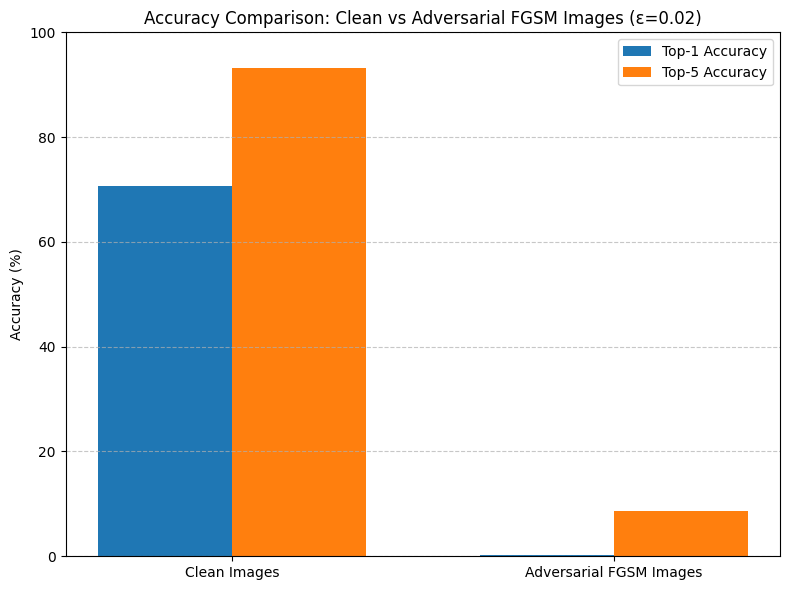

In [ ]:
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load model
    model = load_model().to(device)

    # Load class names and IDs
    labels_json_path = "/content/TestDataSet/labels_list.json"
    class_names, class_ids = load_labels(labels_json_path)

    # Define transformations
    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    # Load dataset
    dataset_path = "/content/TestDataSet"
    dataset = ImageFolder(root=dataset_path, transform=transform)
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Create mappings
    wnids = dataset.classes
    wnid_to_class = {wnid: class_name for wnid, class_name in zip(wnids, class_names)}
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    epsilon = 0.02
    perturbed_images = []
    original_images = []
    true_labels = []
    predictions = []

    # Evaluate original model
    print("Evaluating original model...")
    original_top1, original_top5 = evaluate_model(model, test_loader, device, dataset, wnid_to_class, class_to_idx)
    print(f"Original Model - Top-1 Accuracy: {original_top1:.2f}%, Top-5 Accuracy: {original_top5:.2f}%")

    # Generate adversarial examples
    model.eval()
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Get the true class indices (401-500)
        true_indices = torch.tensor([class_to_idx[wnid_to_class[dataset.classes[label.item()]]] + 401 for label in labels], device=device)

        # Generate perturbed images using momentum I-FGSM
        perturbed = momentum_iterative_fgsm_attack(model, images, epsilon, mean_norms, std_norms, true_indices)

        # Store results
        perturbed_images.extend(perturbed.detach().cpu())
        original_images.extend(images.detach().cpu())
        true_labels.extend(labels.cpu())

        # Get predictions on perturbed images
        with torch.no_grad():
            outputs = model(perturbed)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu())

    # Visualize some examples
    visualize_attacks(
        torch.stack(original_images[:5]),
        torch.stack(perturbed_images[:5]),
        true_labels[:5],
        predictions[:5],
        class_names,
        epsilon
    )

    # Save adversarial dataset
    os.makedirs('adversarial_test_set_2', exist_ok=True)
    for i, (orig, pert) in enumerate(zip(original_images, perturbed_images)):
        # Denormalize images before saving
        orig_img = transforms.ToPILImage()(orig * torch.tensor(std_norms).view(3, 1, 1) + torch.tensor(mean_norms).view(3, 1, 1))
        pert_img = transforms.ToPILImage()(pert * torch.tensor(std_norms).view(3, 1, 1) + torch.tensor(mean_norms).view(3, 1, 1))

        # Save images
        orig_img.save(f'adversarial_test_set_2/original_{i}.png')
        pert_img.save(f'adversarial_test_set_2/perturbed_{i}.png')

    # Create a new dataloader for adversarial examples
    adversarial_dataset = torch.utils.data.TensorDataset(
        torch.stack(perturbed_images),
        torch.tensor(true_labels)
    )
    adversarial_loader = DataLoader(adversarial_dataset, batch_size=32, shuffle=False)

    # Evaluate model on adversarial examples
    print("\nEvaluating model on adversarial examples...")
    adversarial_top1, adversarial_top5 = evaluate_model(model, adversarial_loader, device, dataset, wnid_to_class, class_to_idx)
    print(f"Adversarial Model - Top-1 Accuracy: {adversarial_top1:.2f}%, Top-5 Accuracy: {adversarial_top5:.2f}%")

    # Calculate accuracy drop
    top1_drop = original_top1 - adversarial_top1
    top5_drop = original_top5 - adversarial_top5
    print(f"\nAccuracy Drop - Top-1: {top1_drop:.2f}%, Top-5: {top5_drop:.2f}%")

    # Verify adversarial examples
    print("\nVerifying adversarial examples...")
    verify_adversarial_examples(
        torch.stack(original_images),
        torch.stack(perturbed_images),
        epsilon,
        original_top1,
        original_top5,
        adversarial_top1,
        adversarial_top5
    )

    labels = ['Clean Images', 'Adversarial FGSM Images']  # Changed from 'Patch' to 'FGSM' to match this version
    top1_scores = [original_top1, adversarial_top1]
    top5_scores = [original_top5, adversarial_top5]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 6))
    plt.bar([i - width/2 for i in x], top1_scores, width=width, label='Top-1 Accuracy')
    plt.bar([i + width/2 for i in x], top5_scores, width=width, label='Top-5 Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Accuracy Comparison: Clean vs Adversarial FGSM Images (ε={epsilon})')
    plt.xticks(x, labels)
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

### FGSM Visualization and Top-5 Prediction Analysis

This cell demonstrates the generation and interpretability of adversarial examples using the **Fast Gradient Sign Method (FGSM)** and visualizes their impact on model predictions.

---

1. **Gradient Computation and FGSM Attack**  
   A batch of test images is selected, and the loss gradient with respect to the input is computed using a pretrained ResNet-34 model. The FGSM attack then perturbs the image by adding the sign of the gradient, scaled by $\varepsilon = 0.02$, and constrained under the $\ell_\infty$-norm.

2. **Visual Inspection**  
   For a selected number of examples:
   - The **original image**, **adversarial image**, and the **perturbation (noise)** are displayed side-by-side.
   - A horizontal **bar chart** shows the model’s **Top-5 predicted classes** for each adversarial image, along with their confidence scores.

3. **Purpose**  
   This visualization qualitatively demonstrates how small, imperceptible changes to the input can cause drastic shifts in the model's predictions. It highlights both the **vulnerability** of deep models and the **semantic instability** introduced by adversarial perturbations, helping to analyze common misclassification patterns.

---

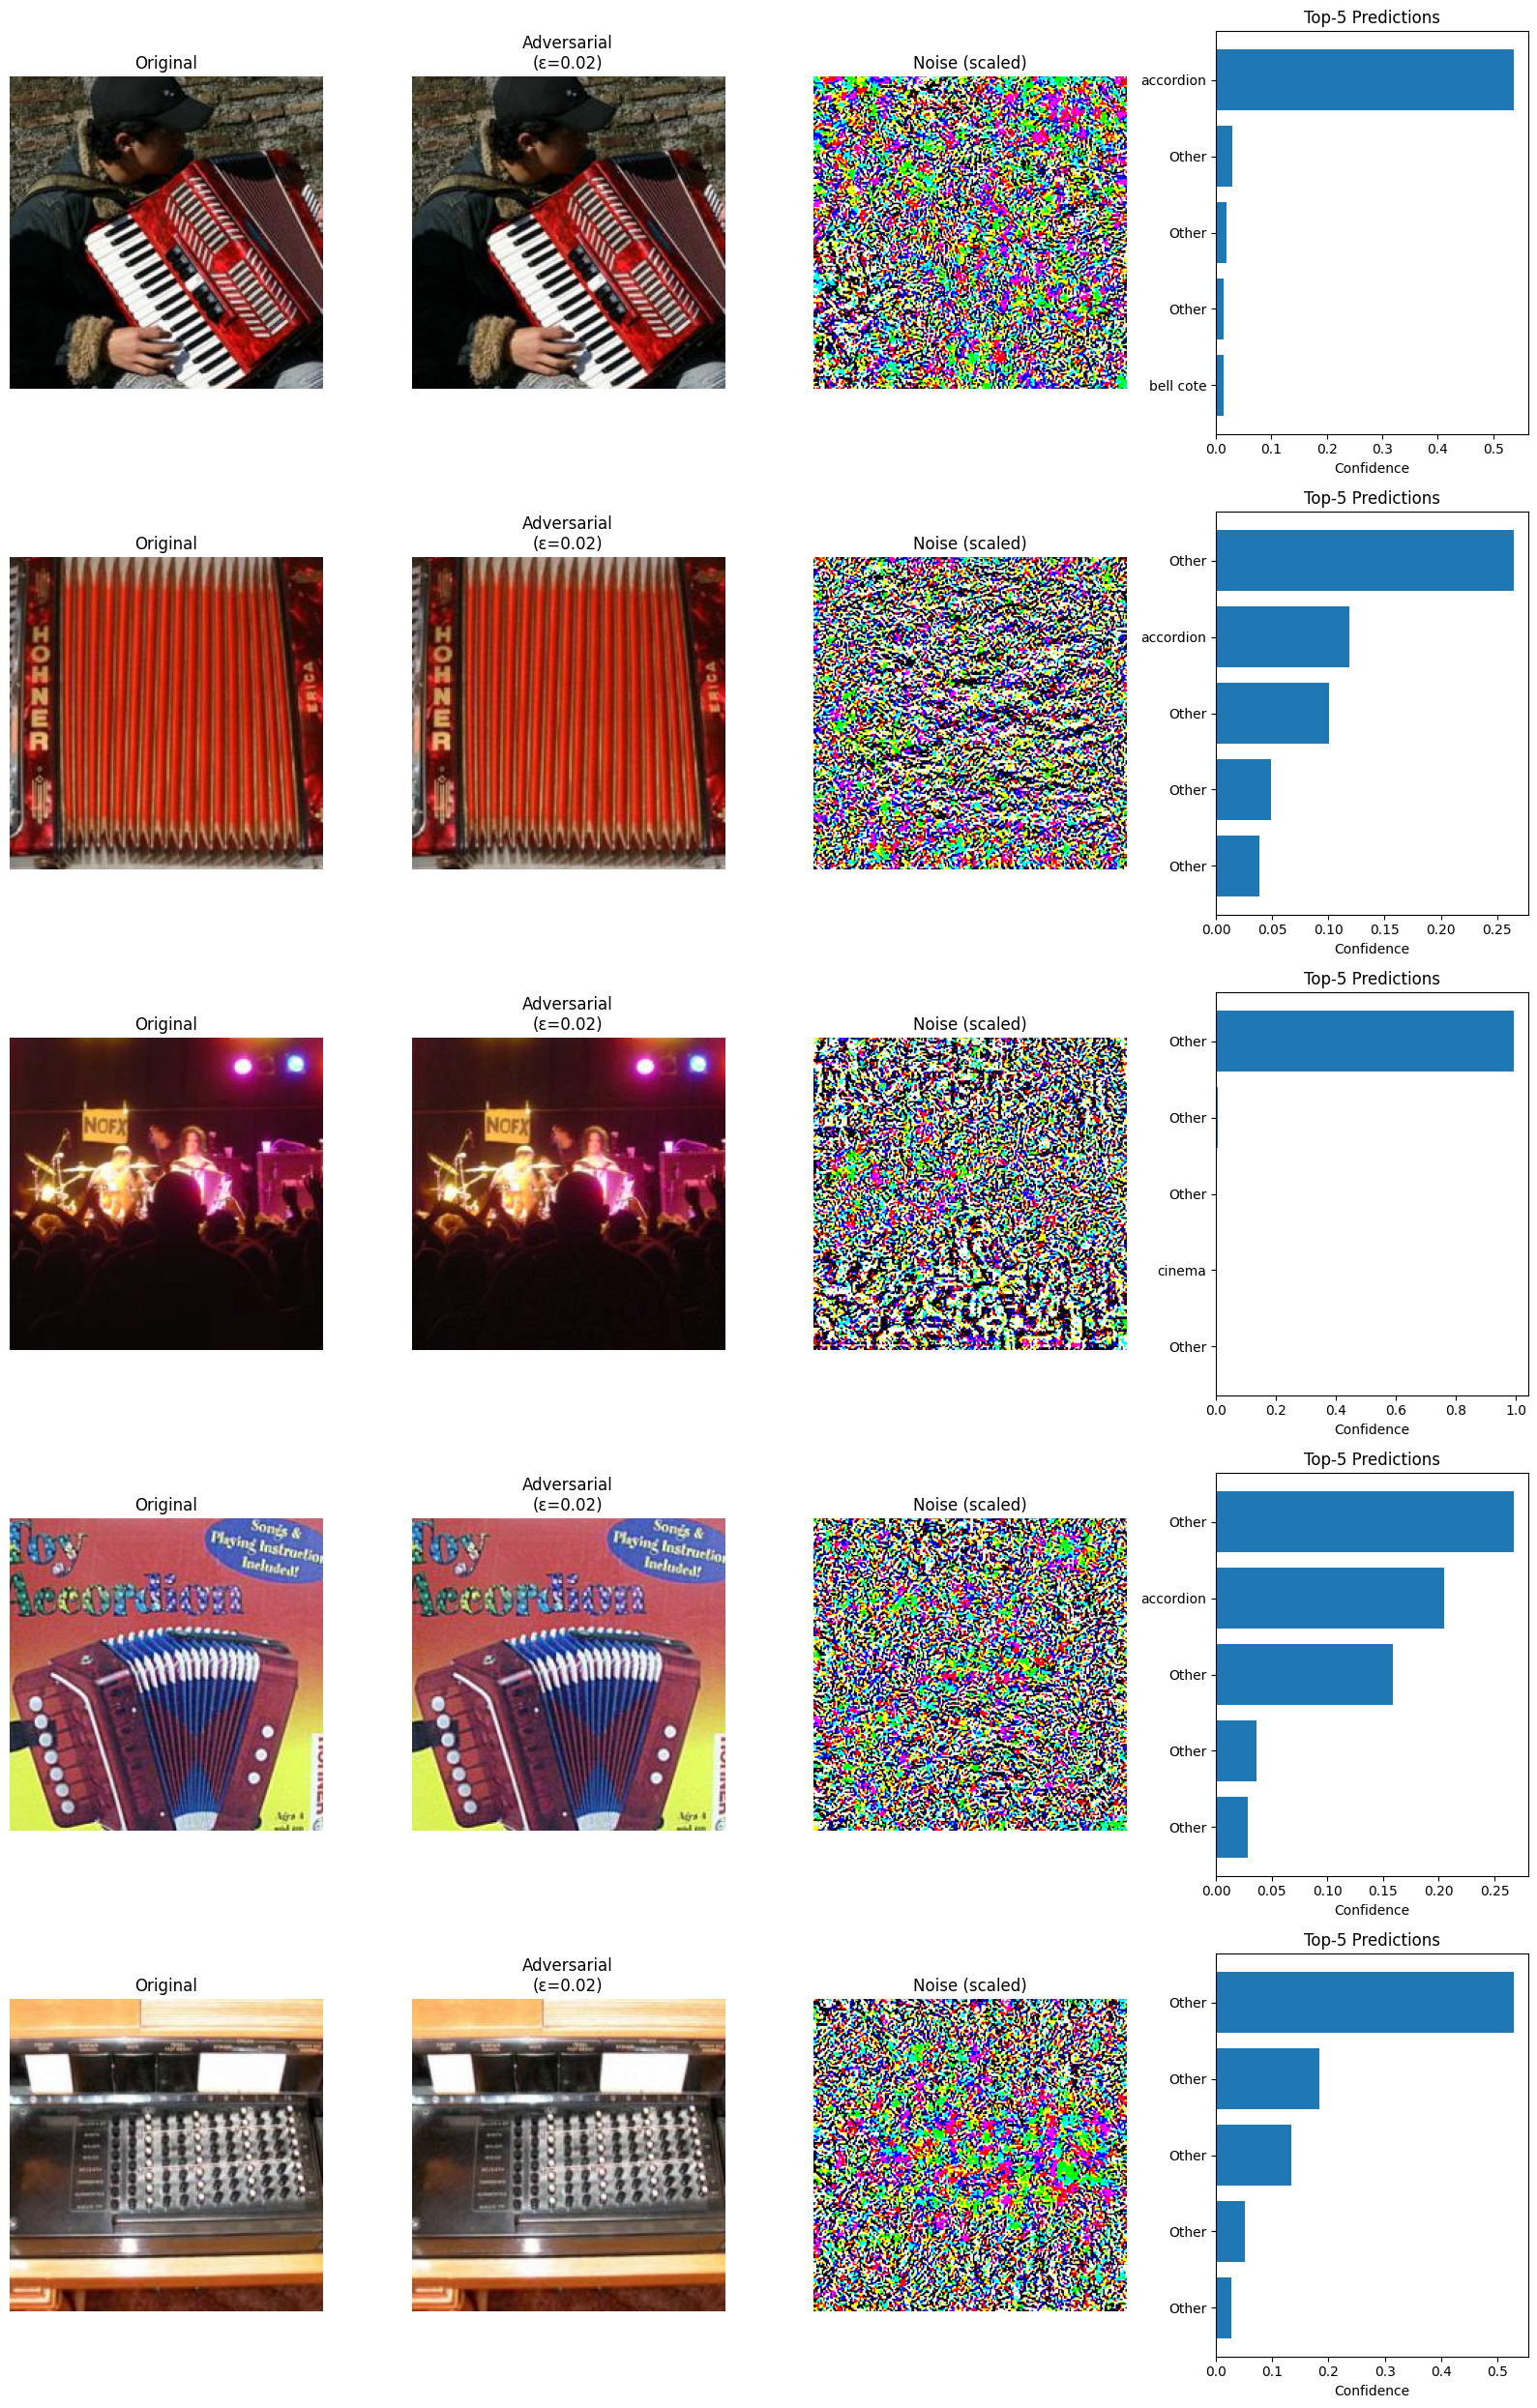

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- FGSM attack (your existing implementation) ---
def fgsm_attack(image, epsilon, data_grad, mean_norms, std_norms):
    mean_tensor = torch.tensor(mean_norms, device=image.device, dtype=torch.float32).view(3,1,1)
    std_tensor  = torch.tensor(std_norms, device=image.device, dtype=torch.float32).view(3,1,1)
    image_denorm = image * std_tensor + mean_tensor

    sign_data_grad = data_grad.sign()
    epsilon_scaled = epsilon * std_tensor

    perturbed = image_denorm + epsilon_scaled * sign_data_grad
    perturbed = torch.clamp(perturbed, 0, 1)
    perturbed = (perturbed - mean_tensor) / std_tensor
    return perturbed

# --- Visualization (with proper .detach() calls) ---
def visualize_with_noise_and_top5(orig_imgs, adv_imgs, data_grads,
                                  model, class_to_idx, idx_to_wnid,
                                  wnid_to_class, epsilon, num_samples=3):
    offset = 401
    num_json = len(idx_to_wnid)
    plt.figure(figsize=(16, 5 * num_samples))

    for i in range(num_samples):
        # detach before any numpy() call
        orig = orig_imgs[i].detach()
        adv  = adv_imgs[i].detach()
        grad = data_grads[i].detach()

        # 1) Original
        plt.subplot(num_samples, 4, 4*i + 1)
        img = orig.permute(1,2,0).numpy()
        img = np.clip(img * std_norms + mean_norms, 0, 1)
        plt.imshow(img); plt.title("Original"); plt.axis('off')

        # 2) Adversarial
        plt.subplot(num_samples, 4, 4*i + 2)
        img_adv = adv.permute(1,2,0).numpy()
        img_adv = np.clip(img_adv * std_norms + mean_norms, 0, 1)
        plt.imshow(img_adv); plt.title(f"Adversarial\n(ε={epsilon})"); plt.axis('off')

        # 3) Noise (scaled)
        plt.subplot(num_samples, 4, 4*i + 3)
        noise_img = (epsilon * grad.sign()).permute(1,2,0).numpy()
        # shift from [-ε,+ε] to [0,1]
        noise_disp = (noise_img + epsilon) / (2 * epsilon)
        plt.imshow(noise_disp); plt.title("Noise (scaled)"); plt.axis('off')

        # 4) Top‑5 Predictions
        plt.subplot(num_samples, 4, 4*i + 4)
        with torch.no_grad():
            out = model(adv.unsqueeze(0).to(device))
            probs = torch.softmax(out, dim=1).cpu().squeeze()
        top5 = torch.topk(probs, 5)
        confs = top5.values.numpy()
        inds  = top5.indices.numpy()

        labels = []
        for idx in inds:
            if offset <= idx < offset + num_json:
                json_idx = idx - offset
                wnid     = idx_to_wnid[json_idx]
                labels.append(wnid_to_class.get(wnid, "Unknown"))
            else:
                labels.append("Other")

        plt.barh(range(5), confs[::-1])
        plt.yticks(range(5), labels[::-1])
        plt.xlabel("Confidence")
        plt.title("Top‑5 Predictions")
        plt.tight_layout()

    plt.show()

# --- MAIN: grab a batch, compute grads, perturb, and visualize ---
# (assumes these are already in your notebook’s global scope:
#   test_loader, model, mean_norms, std_norms,
#   class_to_idx, dataset.classes, wnid_to_class
# )

epsilon = 0.02

# 1) Grab one batch
orig_batch, labels_batch = next(iter(test_loader))
orig_batch = orig_batch.to(device)
labels_batch = labels_batch.to(device)

# 2) Compute gradients w.r.t. inputs
orig_batch.requires_grad_(True)
outputs = model(orig_batch)
true_indices = torch.tensor(
    [ class_to_idx[ wnid_to_class[ dataset.classes[l.item()] ] ] + 401
      for l in labels_batch ],
    device=device
)
loss = torch.nn.CrossEntropyLoss()(outputs, true_indices)
model.zero_grad()
loss.backward()

# 3) Generate adversarial images & grab the gradient
grads     = orig_batch.grad.detach().cpu()
adv_batch = fgsm_attack(orig_batch, epsilon, orig_batch.grad, mean_norms, std_norms).cpu()
orig_cpu  = orig_batch.detach().cpu()

# 4) Visualize first 3 samples
visualize_with_noise_and_top5(
    orig_cpu,
    adv_batch,
    grads,
    model,
    class_to_idx,
    dataset.classes,   # idx_to_wnid
    wnid_to_class,
    epsilon=epsilon,
    num_samples=5
)


<font size="45">Task 4</font>

### Patch-Constrained Momentum Iterative FGSM Attack (Task 4)

This cell implements a localized adversarial attack using the **Patch-based Momentum Iterative FGSM (MI-FGSM)** method. The attack perturbs only a small rectangular region (patch) within each input image, rather than modifying the full image.

---

**Key components of the method:**

- **Patch Confinement**  
  For each image, a fixed-size patch (default: 32×32) is randomly selected near the center. The attack modifies only this region, mimicking realistic physical-world attacks (e.g., adversarial stickers).

- **Momentum Iteration**  
  Gradients are accumulated over multiple iterations (default: 30) using a momentum factor (default: 0.9). This stabilizes the update direction and strengthens the attack’s transferability.

- **Loss Maximization**  
  At every step, cross-entropy loss is computed with respect to the true label. Its gradient is used to craft perturbations that push the model toward misclassification.

- **Step Clipping and Projection**  
  Perturbations are clipped and projected back into an $\ell_\infty$-ball of radius $\epsilon = 0.5$, ensuring that the maximum change to any pixel remains bounded.

- **Normalization-Aware Clipping**  
  Each iteration includes a careful re-clipping of the perturbed patch in both denormalized and normalized image spaces to ensure pixel values remain within $[0, 1]$.

---

This patch-based attack is useful for assessing model robustness under **physically plausible constraints**, offering insight into real-world vulnerabilities beyond synthetic, full-image attacks.


In [ ]:
def load_model():
    # Load pretrained ResNet-34 with updated weights parameter
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.eval()
    return model

def load_labels(labels_json_path):
    with open(labels_json_path, "r") as f:
        label_entries = json.load(f)

    # Build a list of class names and their corresponding ImageNet IDs
    class_names = []
    class_ids = []
    for entry in label_entries:
        match = re.match(r"(\d+): (.+)", entry)
        if match:
            class_id = int(match.group(1))
            class_name = match.group(2).strip()
            class_names.append(class_name)
            class_ids.append(class_id)

    return class_names, class_ids

epsilon = 0.5

In [ ]:
def patch_momentum_iterative_fgsm_attack(model, image, epsilon, mean_norms, std_norms, true_indices, patch_size=32, num_steps=30, step_size=0.01, momentum=0.9):
    # Convert mean and std to tensors with proper shape and type
    mean_tensor = torch.tensor(mean_norms, device=image.device, dtype=torch.float32).view(3, 1, 1)
    std_tensor = torch.tensor(std_norms, device=image.device, dtype=torch.float32).view(3, 1, 1)

    # Ensure image is float32
    image = image.float()

    # Initialize perturbed image
    perturbed_image = image.clone()

    # Generate random patch coordinates
    batch_size = image.size(0)
    height = image.size(2)
    width = image.size(3)

    # Generate random patch positions for each image in the batch
    # Focus on center region for more effective attacks
    center_x = height // 2
    center_y = width // 2
    patch_positions = []
    for _ in range(batch_size):
        x = torch.randint(center_x - patch_size, center_x + patch_size - patch_size + 1, (1,))
        y = torch.randint(center_y - patch_size, center_y + patch_size - patch_size + 1, (1,))
        x = torch.clamp(x, 0, height - patch_size)
        y = torch.clamp(y, 0, width - patch_size)
        patch_positions.append((x.item(), y.item()))

    # Initialize momentum buffer for the patch
    momentum_buffer = torch.zeros_like(image)

    # Scale step size by epsilon
    step_size = epsilon / num_steps

    for _ in range(num_steps):
        # Create a new tensor for gradient computation
        perturbed_image.requires_grad = True

        # Forward pass
        outputs = model(perturbed_image)

        # Use untargeted loss - maximize the loss for true class
        loss = nn.CrossEntropyLoss()(outputs, true_indices)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Get gradient
        data_grad = perturbed_image.grad.data

        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()

        # Update momentum buffer
        momentum_buffer = momentum * momentum_buffer + step_size * sign_data_grad

        # Create the perturbed image by adjusting each pixel
        perturbed_image = perturbed_image.detach() + momentum_buffer

        # Apply perturbations only to the patch regions
        for i, (x, y) in enumerate(patch_positions):
            # Project back to epsilon ball in normalized space
            delta = perturbed_image[i, :, x:x+patch_size, y:y+patch_size] - image[i, :, x:x+patch_size, y:y+patch_size]
            delta = torch.clamp(delta, -epsilon, epsilon)
            perturbed_image[i, :, x:x+patch_size, y:y+patch_size] = image[i, :, x:x+patch_size, y:y+patch_size] + delta

            # Adding clipping to maintain [0,1] range after denormalization
            patch_denorm = perturbed_image[i, :, x:x+patch_size, y:y+patch_size] * std_tensor + mean_tensor
            patch_denorm = torch.clamp(patch_denorm, 0, 1)
            perturbed_image[i, :, x:x+patch_size, y:y+patch_size] = (patch_denorm - mean_tensor) / std_tensor

            # Zero out momentum buffer outside the patch
            momentum_buffer[i, :, :x, :] = 0
            momentum_buffer[i, :, x+patch_size:, :] = 0
            momentum_buffer[i, :, :, :y] = 0
            momentum_buffer[i, :, :, y+patch_size:] = 0

    # Final projection to ensure constraint
    for i, (x, y) in enumerate(patch_positions):
        delta = perturbed_image[i, :, x:x+patch_size, y:y+patch_size] - image[i, :, x:x+patch_size, y:y+patch_size]
        delta = torch.clamp(delta, -epsilon, epsilon)
        perturbed_image[i, :, x:x+patch_size, y:y+patch_size] = image[i, :, x:x+patch_size, y:y+patch_size] + delta

        # Final clipping to maintain [0,1] range after denormalization
        patch_denorm = perturbed_image[i, :, x:x+patch_size, y:y+patch_size] * std_tensor + mean_tensor
        patch_denorm = torch.clamp(patch_denorm, 0, 1)
        perturbed_image[i, :, x:x+patch_size, y:y+patch_size] = (patch_denorm - mean_tensor) / std_tensor

    return perturbed_image

### Model Evaluation, Visualization, and Verification of Adversarial Examples

This cell performs three key functions as part of evaluating the effect of adversarial attacks:

---

1. **Model Evaluation (Top-1 and Top-5 Accuracy):**  
   The `evaluate_model` function computes classification accuracy of the model on a dataset by comparing predicted labels to true ImageNet class indices. Specifically:
   - **Top-1 Accuracy**: Percentage of samples where the top predicted class matches the ground truth.
   - **Top-5 Accuracy**: Percentage of samples where the ground truth label appears among the top 5 predictions.

---

2. **Attack Visualization:**  
   The `visualize_attacks` function displays a side-by-side comparison of original and perturbed images for a selected batch. Each row includes:
   - The clean (original) image with its true and predicted class.
   - The adversarially perturbed image, annotated with its updated prediction.
   - Denormalization is applied before plotting to map pixel values from normalized space back to the range $[0, 1]$ for proper visual interpretation.

---

3. **Verification of Adversarial Perturbation Magnitude:**  
   The `verify_adversarial_examples` function checks whether each adversarial example satisfies the $\ell_{\infty}$ constraint defined by $\epsilon$. For every image pair:
   - The maximum absolute pixel difference across all channels (i.e., $\|x_{\text{adv}} - x\|_{\infty}$) is computed.
   - A count is maintained of how many adversarial samples stay within the specified $\epsilon$-ball.
   - Mean, maximum, and minimum $\ell_{\infty}$ distances are logged.
   - Additionally, this function records the drop in top-1 and top-5 accuracy between clean and adversarial inputs to quantify attack strength.

---

Together, these utilities ensure that the crafted adversarial examples are **effective** (they induce misclassification) and **constrained** (they remain visually imperceptible under the $\ell_{\infty}$ norm).


In [ ]:
def evaluate_model(model, dataloader, device, dataset, wnid_to_class, class_to_idx):
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)

            for i in range(images.size(0)):
                true_wnid = dataset.classes[labels[i].item()]
                true_class_name = wnid_to_class[true_wnid]
                true_imagenet_idx = class_to_idx[true_class_name] + 401  # adjust offset if needed

                if predicted[i].item() == true_imagenet_idx:
                    correct_top1 += 1
                if true_imagenet_idx in top5_preds[i].tolist():
                    correct_top5 += 1
                total += 1

    top1_accuracy = 100. * correct_top1 / total
    top5_accuracy = 100. * correct_top5 / total
    return top1_accuracy, top5_accuracy


In [ ]:
def visualize_attacks(original_images, perturbed_images, labels, predictions, class_names, epsilon, num_samples=5):
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2*i + 1)
        # Denormalize and convert to numpy for visualization
        orig_img = original_images[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(orig_img)

        # Get true class name
        true_class_idx = labels[i].item()
        true_class_name = class_names[true_class_idx]

        # Get predicted class name (adjust for ImageNet offset)
        pred_idx = predictions[i].item()
        pred_class_name = class_names[pred_idx - 401] if 401 <= pred_idx <= 500 else "Unknown"

        plt.title(f'Original\nTrue: {true_class_name}\nPred: {pred_class_name}')
        plt.axis('off')

        # Perturbed image
        plt.subplot(num_samples, 2, 2*i + 2)
        # Denormalize and convert to numpy for visualization
        pert_img = perturbed_images[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
        pert_img = np.clip(pert_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(pert_img)
        plt.title(f'Perturbed (ε={epsilon})\nTrue: {true_class_name}\nPred: {pred_class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('task3_improved_attack_visualization.png')
    plt.close()

In [ ]:
def verify_adversarial_examples(original_images, perturbed_images, epsilon, original_top1, original_top5, adversarial_top1, adversarial_top5):
    # Calculate L∞ distance for each image pair
    distances = []
    for orig, pert in zip(original_images, perturbed_images):
        # Calculate absolute difference
        diff = torch.abs(pert - orig)
        # Get maximum difference (L∞ norm)
        max_diff = torch.max(diff).item()
        distances.append(max_diff)

    # Convert to numpy for easier analysis
    distances = np.array(distances)

    # Use a small tolerance for floating-point comparisons
    tolerance = 1e-6
    within_limit = np.sum(distances <= epsilon + tolerance)

    # Calculate accuracy drops
    top1_drop = original_top1 - adversarial_top1
    top5_drop = original_top5 - adversarial_top5

    # Print statistics
    print("\nVerification Results:")
    print(f"Number of images: {len(distances)}")
    print(f"Maximum L∞ distance: {np.max(distances):.6f}")
    print(f"Minimum L∞ distance: {np.min(distances):.6f}")
    print(f"Mean L∞ distance: {np.mean(distances):.6f}")
    print(f"Images within ε={epsilon} limit: {within_limit}/{len(distances)}")

    # Save verification results
    with open('adversarial_test_set_3/verification_results.txt', 'w') as f:
        f.write(f"Verification Results for Adversarial Test Set 3\n")
        f.write(f"=============================================\n")
        f.write(f"Number of images: {len(distances)}\n")
        f.write(f"Maximum L∞ distance: {np.max(distances):.6f}\n")
        f.write(f"Minimum L∞ distance: {np.min(distances):.6f}\n")
        f.write(f"Mean L∞ distance: {np.mean(distances):.6f}\n")
        f.write(f"Images within ε={epsilon} limit: {within_limit}/{len(distances)}\n")
        f.write(f"\nOriginal Model Accuracy:\n")
        f.write(f"Top-1: {original_top1:.2f}%\n")
        f.write(f"Top-5: {original_top5:.2f}%\n")
        f.write(f"\nAdversarial Model Accuracy:\n")
        f.write(f"Top-1: {adversarial_top1:.2f}%\n")
        f.write(f"Top-5: {adversarial_top5:.2f}%\n")
        f.write(f"\nAccuracy Drop:\n")
        f.write(f"Top-1: {top1_drop:.2f}%\n")
        f.write(f"Top-5: {top5_drop:.2f}%\n")


### Patch-based Momentum Iterative FGSM Attack and Evaluation

This cell orchestrates the full workflow for evaluating a ResNet-34 model under **adversarial patch attacks** using the momentum iterative variant of the Fast Gradient Sign Method (MI-FGSM). The key steps are as follows:

---

- **Model Initialization & Dataset Loading**  
  A pretrained `ResNet-34` model is loaded using `torchvision.models`. The evaluation is performed on a subset of the ImageNet-1K dataset. Input images are resized, center-cropped to $224 \times 224$, normalized using standard ImageNet mean and standard deviation, and loaded into batches via `DataLoader`.

---

- **Clean Accuracy Evaluation**  
  The original **Top-1** and **Top-5** classification accuracy of the model is computed over the clean dataset.  
  - **Top-1 Accuracy**: Measures how often the model's top prediction matches the ground truth.  
  - **Top-5 Accuracy**: Measures how often the correct label appears in the top 5 predictions.

---

- **Patch-based Adversarial Example Generation**  
  For each batch:
  - A square patch of size $p \times p$ (default: $p = 32$) is randomly selected near the center of the image.
  - The MI-FGSM attack is applied **only within this patch**, using the following update rules:
    \[
    g_{t+1} = \mu \cdot g_t + \nabla_x J(\theta, x_t, y)
    \]
    \[
    x_{t+1}^{\text{patch}} = \text{Clip}_\epsilon\left(x_t^{\text{patch}} + \alpha \cdot \text{sign}(g_{t+1})\right)
    \]
    where:
    - $\mu$ is the momentum factor  
    - $\epsilon$ is the maximum allowed perturbation under the $\ell_{\infty}$ norm  
    - $\alpha$ is the per-step perturbation size  
  - After each iteration, the perturbed patch is projected back into the valid image space and renormalized to match input distribution constraints.

---

- **Adversarial Evaluation & Comparison**  
  The adversarial images are re-evaluated using the same model. Top-1 and Top-5 accuracies are recomputed and compared against the clean baseline to quantify performance degradation.

---

- **Verification & Visualization**  
  The `verify_adversarial_examples()` function confirms that all perturbations stay within the defined $\ell_{\infty}$-norm bound ($\epsilon$) for the patch. Additionally:
  - A bar chart compares clean and adversarial accuracy.
  - Side-by-side image visualizations are saved to demonstrate qualitative differences between clean and attacked samples.

---

This end-to-end process illustrates how **localized adversarial perturbations**—even when constrained to a small patch—can lead to significant drops in model accuracy, underscoring the real-world threat of patch-based attacks.

Using device: cuda
Evaluating original model...


100%|██████████| 16/16 [00:01<00:00, 13.05it/s]


Original Model - Top-1 Accuracy: 70.60%, Top-5 Accuracy: 93.20%


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]



Evaluating model on adversarial examples...


100%|██████████| 16/16 [00:00<00:00, 67.92it/s]


Adversarial Model - Top-1 Accuracy: 0.00%, Top-5 Accuracy: 2.00%

Accuracy Drop - Top-1: 70.60%, Top-5: 91.20%

Verifying adversarial examples...

Verification Results:
Number of images: 500
Maximum L∞ distance: 0.050004
Minimum L∞ distance: 0.050000
Mean L∞ distance: 0.050003
Images within ε=0.5 limit: 500/500


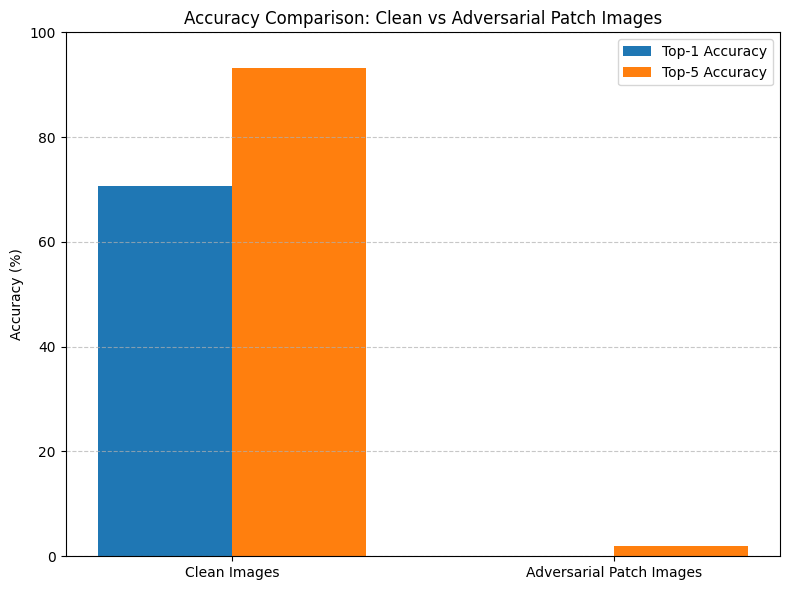

In [ ]:
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load model
    model = load_model().to(device)

    # Load class names and IDs
    labels_json_path = "/content/TestDataSet/labels_list.json"
    class_names, class_ids = load_labels(labels_json_path)

    # Define transformations
    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    # Load dataset
    dataset_path = "/content/TestDataSet"
    dataset = ImageFolder(root=dataset_path, transform=transform)
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Create mappings
    wnids = dataset.classes
    wnid_to_class = {wnid: class_name for wnid, class_name in zip(wnids, class_names)}
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    epsilon = 0.5  # Increased epsilon for patch attack
    perturbed_images = []
    original_images = []
    true_labels = []
    predictions = []

    # Evaluate original model
    print("Evaluating original model...")
    original_top1, original_top5 = evaluate_model(model, test_loader, device, dataset, wnid_to_class, class_to_idx)
    print(f"Original Model - Top-1 Accuracy: {original_top1:.2f}%, Top-5 Accuracy: {original_top5:.2f}%")

    # Generate adversarial examples
    model.eval()
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Get the true class indices (401-500)
        true_indices = torch.tensor([class_to_idx[wnid_to_class[dataset.classes[label.item()]]] + 401 for label in labels], device=device)

        # Generate perturbed images using patch momentum I-FGSM
        perturbed = patch_momentum_iterative_fgsm_attack(model, images, 0.05, mean_norms, std_norms, true_indices)

        # Store results
        perturbed_images.extend(perturbed.detach().cpu())
        original_images.extend(images.detach().cpu())
        true_labels.extend(labels.cpu())

        # Get predictions on perturbed images
        with torch.no_grad():
            outputs = model(perturbed)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu())

    # Visualize some examples
    visualize_attacks(
        torch.stack(original_images[:5]),
        torch.stack(perturbed_images[:5]),
        true_labels[:5],
        predictions[:5],
        class_names,
        epsilon
    )

    # Save adversarial dataset
    os.makedirs('adversarial_test_set_3', exist_ok=True)
    for i, (orig, pert) in enumerate(zip(original_images, perturbed_images)):
        # Denormalize images before saving
        orig_img = transforms.ToPILImage()(orig * torch.tensor(std_norms).view(3, 1, 1) + torch.tensor(mean_norms).view(3, 1, 1))
        pert_img = transforms.ToPILImage()(pert * torch.tensor(std_norms).view(3, 1, 1) + torch.tensor(mean_norms).view(3, 1, 1))

        # Save images
        orig_img.save(f'adversarial_test_set_3/original_{i}.png')
        pert_img.save(f'adversarial_test_set_3/perturbed_{i}.png')

    # Create a new dataloader for adversarial examples
    adversarial_dataset = torch.utils.data.TensorDataset(
        torch.stack(perturbed_images),
        torch.tensor(true_labels)
    )
    adversarial_loader = DataLoader(adversarial_dataset, batch_size=32, shuffle=False)

    # Evaluate model on adversarial examples
    print("\nEvaluating model on adversarial examples...")
    adversarial_top1, adversarial_top5 = evaluate_model(model, adversarial_loader, device, dataset, wnid_to_class, class_to_idx)
    print(f"Adversarial Model - Top-1 Accuracy: {adversarial_top1:.2f}%, Top-5 Accuracy: {adversarial_top5:.2f}%")

    # Calculate accuracy drop
    top1_drop = original_top1 - adversarial_top1
    top5_drop = original_top5 - adversarial_top5
    print(f"\nAccuracy Drop - Top-1: {top1_drop:.2f}%, Top-5: {top5_drop:.2f}%")

    # Verify adversarial examples
    print("\nVerifying adversarial examples...")
    verify_adversarial_examples(
        torch.stack(original_images),
        torch.stack(perturbed_images),
        epsilon,
        original_top1,
        original_top5,
        adversarial_top1,
        adversarial_top5
    )

    labels = ['Clean Images', 'Adversarial Patch Images']
    top1_scores = [original_top1, adversarial_top1]
    top5_scores = [original_top5, adversarial_top5]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 6))
    plt.bar([i - width/2 for i in x], top1_scores, width=width, label='Top-1 Accuracy')
    plt.bar([i + width/2 for i in x], top5_scores, width=width, label='Top-5 Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison: Clean vs Adversarial Patch Images')
    plt.xticks(x, labels)
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

### Adversarial Dataset Cleanup Utility

This cell provides a utility function to validate and clean adversarial image datasets. Each adversarial test set is expected to contain exactly 500 images named in the format `perturbed_0.png` to `perturbed_499.png`.

**Functionality:**
- **Directory Check:** Verifies whether the specified directory exists for each adversarial test set.
- **File Validation:** Scans all `.png` files in the directory and removes any files that do not match the expected naming convention.
- **Patch Integrity Check:** Confirms that the remaining files in the directory match exactly the 500 expected filenames.
- **Status Summary:** After processing all three sets, prints a final summary indicating whether all datasets are now valid and consistent.

This script is important to maintain consistency and prevent evaluation errors caused by extraneous or missing files in the adversarial datasets.

In [ ]:
import os

def clean_adversarial_dataset(set_name, set_path):
    print(f"\nCleaning {set_name} at {set_path}...")
    print("=" * 50)

    # Check if directory exists
    if not os.path.exists(set_path):
        print(f"ERROR: Directory {set_path} does not exist!")
        return False

    # Get list of all PNG files
    files = [f for f in os.listdir(set_path) if f.endswith('.png')]
    expected_files = [f"perturbed_{i}.png" for i in range(500)]

    # Identify and remove unexpected files
    unexpected_files = [f for f in files if f not in expected_files]
    if unexpected_files:
        print(f"Removing {len(unexpected_files)} unexpected files...")
        for f in unexpected_files:
            os.remove(os.path.join(set_path, f))
            print(f"  - Removed {f}")
    else:
        print("No unexpected files found.")

    # Verify remaining files
    remaining_files = [f for f in os.listdir(set_path) if f.endswith('.png')]
    if len(remaining_files) == 500 and all(f in expected_files for f in remaining_files):
        print("Directory now contains exactly 500 perturbed images!")
        return True
    else:
        print(f"Directory contains {len(remaining_files)} files. Expected 500.")
        return False

def main():
    # Define paths to adversarial datasets
    adversarial_sets = [
        ("Adversarial Test Set 1", "adversarial_test_set_1"),
        ("Adversarial Test Set 2", "adversarial_test_set_2"),
        ("Adversarial Test Set 3", "adversarial_test_set_3")
    ]

    # Clean each dataset
    all_valid = True
    for set_name, set_path in adversarial_sets:
        valid = clean_adversarial_dataset(set_name, set_path)
        all_valid = all_valid and valid

    if all_valid:
        print("\nAll adversarial datasets are now clean with 500 images each!")
    else:
        print("\nSome adversarial datasets still have issues. Please check the output above.")

if __name__ == "__main__":
    main()


Cleaning Adversarial Test Set 1 at adversarial_test_set_1...
Removing 500 unexpected files...
  - Removed original_450.png
  - Removed original_176.png
  - Removed original_38.png
  - Removed original_318.png
  - Removed original_381.png
  - Removed original_488.png
  - Removed original_35.png
  - Removed original_485.png
  - Removed original_369.png
  - Removed original_431.png
  - Removed original_42.png
  - Removed original_215.png
  - Removed original_226.png
  - Removed original_466.png
  - Removed original_260.png
  - Removed original_443.png
  - Removed original_469.png
  - Removed original_164.png
  - Removed original_112.png
  - Removed original_27.png
  - Removed original_486.png
  - Removed original_476.png
  - Removed original_33.png
  - Removed original_110.png
  - Removed original_228.png
  - Removed original_121.png
  - Removed original_288.png
  - Removed original_448.png
  - Removed original_29.png
  - Removed original_232.png
  - Removed original_446.png
  - Removed 

### TASK 5: Evaluating Adversarial Transferability on DenseNet-121

This notebook evaluates the robustness of a pre-trained **DenseNet-121** model against various adversarially perturbed image datasets. The adversarial examples were generated using three different attack strategies, and their **transferability** is tested on a model not used during their generation.

---

**Key Components:**

- **Model Loading**  
  A pretrained DenseNet-121 model is loaded from `torchvision` and set to evaluation mode.

- **Label Mapping**  
  A custom label list from `labels_list.json` is used to map WordNet IDs (WNIDs) to ImageNet class indices.

- **Input Transformations**  
  Evaluation images undergo:
  - **JPEG compression** and **Gaussian blur** to simulate realistic test-time distortions.
  - Followed by resize, center crop, normalization, and tensor conversion.

- **Evaluation Pipeline**  
  Top-1 and Top-5 accuracies are computed using the following definitions:
  - **Top-1 Accuracy**: Percentage of images where the model's top prediction exactly matches the ground truth label.
  - **Top-5 Accuracy**: Percentage of images where the ground truth label appears among the model’s top 5 predictions.
  - The true ImageNet index is computed as:
    \[
    \text{true\_imagenet\_idx} = \text{class\_to\_idx}(y_{\text{true}}) + 401
    \]

---

**Evaluated Datasets:**
- **Clean Dataset** (unaltered)
- **Adversarial Test Set 1**: FGSM-based attacks
- **Adversarial Test Set 2**: Momentum-based iterative attacks
- **Adversarial Test Set 3**: Patch-based attacks

---

**Visualization**  
A bar chart is generated to compare **Top-1** and **Top-5** accuracy across the four datasets. This illustrates:
- The effectiveness of each attack strategy
- The degree to which adversarial examples crafted on ResNet-34 transfer to DenseNet-121

---

**Output Files**
- A `.txt` file logging accuracy metrics across datasets
- A `.png` bar chart comparing model performance under clean and adversarial conditions

---

This task provides insight into the **black-box vulnerability** of deep models by evaluating how transferable adversarial attacks are across architectures.


Using device: cuda

Evaluating DenseNet-121 on original dataset...


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Original Dataset - Top-1 Accuracy: 69.60%, Top-5 Accuracy: 90.80%

Evaluating DenseNet-121 on Adversarial Test Set 1...


100%|██████████| 16/16 [00:00<00:00, 35.39it/s]


Adversarial Test Set 1 - Top-1 Accuracy: 57.80%, Top-5 Accuracy: 82.00%

Evaluating DenseNet-121 on Adversarial Test Set 2...


100%|██████████| 16/16 [00:00<00:00, 34.76it/s]


Adversarial Test Set 2 - Top-1 Accuracy: 57.80%, Top-5 Accuracy: 82.40%

Evaluating DenseNet-121 on Adversarial Test Set 3...


100%|██████████| 16/16 [00:00<00:00, 35.96it/s]


Adversarial Test Set 3 - Top-1 Accuracy: 57.80%, Top-5 Accuracy: 81.40%

Summary of Results on DenseNet-121:
Dataset                   Top-1 Accuracy  Top-5 Accuracy 
--------------------------------------------------
Original                  69.60           90.80          
Adversarial Test Set 1    57.80           82.00          
Adversarial Test Set 2    57.80           82.40          
Adversarial Test Set 3    57.80           81.40          


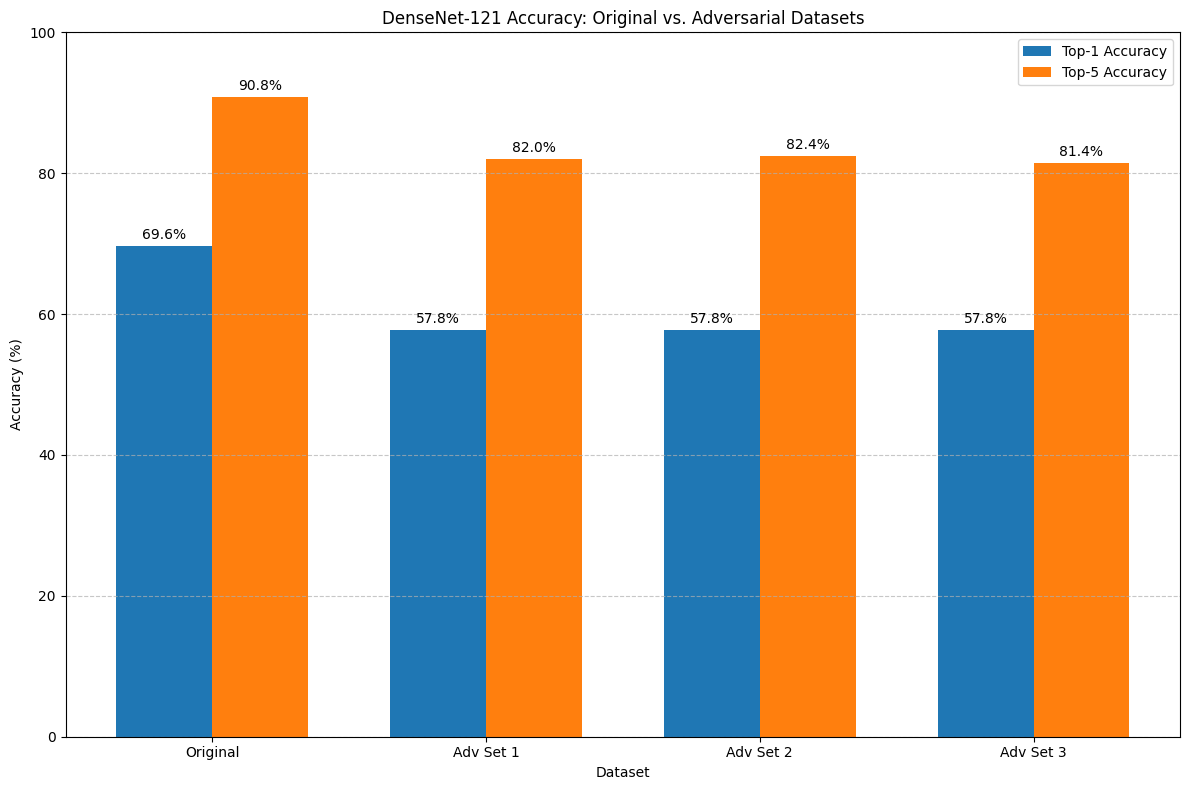

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from tqdm import tqdm


# To load the preferred model DenseNet-121 and set it to evalutation model
def load_model():
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    model.eval()
    return model

def load_labels(labels_json_path):
    with open(labels_json_path, "r") as f:
        label_entries = json.load(f)
    class_names = []
    class_ids = []
    for entry in label_entries:
        match = re.match(r"(\d+): (.+)", entry)
        if match:
            class_id = int(match.group(1))
            class_name = match.group(2).strip()
            class_names.append(class_name)
            class_ids.append(class_id)
    return class_names, class_ids

#Evaluation the model and comparing accuracies
def evaluate_model(model, dataloader, device, dataset, wnid_to_class, class_to_idx):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            _, top5_preds = outputs.topk(5, 1, largest=True, sorted=True)
            for i in range(images.size(0)):
                true_wnid = dataset.classes[labels[i].item()] if dataset else None
                true_class_name = wnid_to_class[true_wnid] if true_wnid else class_names[labels[i].item()]
                true_imagenet_idx = class_to_idx[true_class_name] + 401
                if predicted[i].item() == true_imagenet_idx:
                    correct_top1 += 1
                if true_imagenet_idx in top5_preds[i].tolist():
                    correct_top5 += 1
                total += 1
    top1_accuracy = 100. * correct_top1 / total
    top5_accuracy = 100. * correct_top5 / total
    return top1_accuracy, top5_accuracy

# Function to plot accuracy comparison
def plot_accuracy_comparison(results):
    """
    Create a bar chart comparing Top-1 and Top-5 accuracies across all datasets

    Args:
        results: Dictionary with dataset names as keys and accuracy values as values
    """
    # Extract dataset names and accuracies
    dataset_names = list(results.keys())
    top1_scores = [results[name]['Top-1'] for name in dataset_names]
    top5_scores = [results[name]['Top-5'] for name in dataset_names]

    # For better display, use shorter names
    display_names = [
        'Original',
        'Adv Set 1',
        'Adv Set 2',
        'Adv Set 3'
    ]

    # Set up figure
    plt.figure(figsize=(12, 8))

    # Position of bars on x-axis
    x = np.arange(len(display_names))
    width = 0.35  # width of bars

    # Create bars
    plt.bar(x - width/2, top1_scores, width, label='Top-1 Accuracy')
    plt.bar(x + width/2, top5_scores, width, label='Top-5 Accuracy')

    # Add labels, title and legend
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy (%)')
    plt.title('DenseNet-121 Accuracy: Original vs. Adversarial Datasets')
    plt.xticks(x, display_names)
    plt.ylim(0, 100)  # Set y-axis from 0 to 100%
    plt.legend()

    # Add value labels on the bars
    for i, v in enumerate(top1_scores):
        plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center')

    for i, v in enumerate(top5_scores):
        plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center')

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot
    plt.savefig('accuracy_comparison.png')

    # Show the plot
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = load_model().to(device)

    labels_json_path = "/content/TestDataSet/labels_list.json"
    class_names, class_ids = load_labels(labels_json_path)

    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])
    def jpeg_compression(img):
        img.save("temp.jpg", quality=90)
        return Image.open("temp.jpg").convert("RGB")
#Define the transform
    transform = transforms.Compose([
        transforms.Lambda(jpeg_compression), #compress jpeg file
        transforms.GaussianBlur(kernel_size=3, sigma=0.5), #apply gaussain blur
        transforms.Resize(256), #resize
        transforms.CenterCrop(224), #Crop to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    dataset_path = "/content/TestDataSet"
    dataset = ImageFolder(root=dataset_path, transform=transform)
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    wnids = dataset.classes
    wnid_to_class = {wnid: class_name for wnid, class_name in zip(wnids, class_names)}
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    adversarial_sets = [
        ("Adversarial Test Set 1", "adversarial_test_set_1"),
        ("Adversarial Test Set 2", "adversarial_test_set_2"),
        ("Adversarial Test Set 3", "adversarial_test_set_3")
    ]

    results = {}

    print("\nEvaluating DenseNet-121 on original dataset...")
    original_top1, original_top5 = evaluate_model(model, test_loader, device, dataset, wnid_to_class, class_to_idx)
    results["Original"] = {"Top-1": original_top1, "Top-5": original_top5}
    print(f"Original Dataset - Top-1 Accuracy: {original_top1:.2f}%, Top-5 Accuracy: {original_top5:.2f}%")

    for set_name, set_path in adversarial_sets:
        print(f"\nEvaluating DenseNet-121 on {set_name}...")
        perturbed_images = []
        true_labels = []
        for i in range(500):
            pert_img = Image.open(f"{set_path}/perturbed_{i}.png")
            pert_img = transform(pert_img).cpu()
            perturbed_images.append(pert_img)
            orig_path = dataset.samples[i][0]
            label = dataset.classes.index(orig_path.split('/')[-2])
            true_labels.append(label)

        adversarial_dataset = TensorDataset(
            torch.stack(perturbed_images),
            torch.tensor(true_labels)
        )
        adversarial_loader = DataLoader(adversarial_dataset, batch_size=32, shuffle=False)

        adv_top1, adv_top5 = evaluate_model(model, adversarial_loader, device, dataset, wnid_to_class, class_to_idx)
        results[set_name] = {"Top-1": adv_top1, "Top-5": adv_top5}
        print(f"{set_name} - Top-1 Accuracy: {adv_top1:.2f}%, Top-5 Accuracy: {adv_top5:.2f}%")

    print("\nSummary of Results on DenseNet-121:")
    print("=" * 50)
    print(f"{'Dataset':<25} {'Top-1 Accuracy':<15} {'Top-5 Accuracy':<15}")
    print("-" * 50)
    for dataset_name, accuracies in results.items():
        print(f"{dataset_name:<25} {accuracies['Top-1']:<15.2f} {accuracies['Top-5']:<15.2f}")
    print("=" * 50)


    with open('task5_output.txt', 'w') as f:
        f.write("Task 5: Transferability Results on DenseNet-121\n")
        f.write("=" * 50 + "\n")
        f.write(f"{'Dataset':<25} {'Top-1 Accuracy':<15} {'Top-5 Accuracy':<15}\n")
        f.write("-" * 50 + "\n")
        for dataset_name, accuracies in results.items():
            f.write(f"{dataset_name:<25} {accuracies['Top-1']:<15.2f} {accuracies['Top-5']:<15.2f}\n")

    # Create and save the bar chart visualization
    plot_accuracy_comparison(results)

if __name__ == "__main__":
    main()